# `Практикум по программированию на языке Python`

## `Задание 02. Сегментация изображений`

#### Фамилия, имя: Никишкина Евгения

Дата выдачи: <span style="color:red">__18 марта 17:00__</span>.

Мягкий дедлайн: <span style="color:red">__01 апреля 23:59__</span>.

Стоимость: __10 баллов__ (основная часть заданий) + __4.25 балла__ (дополнительные задания).

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

#### `Москва, 2023`

В этом задании вы будете решать задачу сегментации людей на фотографии с помощью нейросетевых архитектур `U-Net` и `LinkNet`. 

Данные для выполнения задания можно скачать по [ссылке](https://disk.yandex.ru/d/tI6d3LBMHTwOnw).

## `Загрузка данных (1 балл)`

Для загрузки данных pytorch опирается на такую сущность, как **`Dataset`**.

Этот абстрактный класс определен в `torch.utils.data.dataset`:

```python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```
При определении нового источника данных мы создаем наследника данного класса и реализуем методы `__getitem__` и `__len__`.

Пример готового такого класса — `torchvision.datasets.ImageFolder`, который позволяет создать датасет на основе директории с ImageNet-подобной структурой поддиректорий (`./train/{class}` и `./val/{class}`):

```python
imagenet = torchvision.datasets.ImageFolder('path/to/imagenet_root/')
```

Реализуйте класс `PhotosDataset` для выданных данных.

**Внимание.** Возможно, стоит прочитать следующий пункт задания, чтобы реализация была удобной.

In [69]:
import os

import numpy as np
import numpy.testing as npt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg13, VGG13_Weights
from torchvision import transforms
from torchvision.transforms import Compose, Normalize

import matplotlib_inline
import matplotlib.pyplot as plt

from PIL import Image
from PIL import ImageEnhance

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

In [3]:
class PhotosDataset(Dataset):
    def __init__(self, images_dir, target_dir=None, transforms=None):
        """
        Arguments
        ---------
        images_dir : str
            Path to directory with images
            
        target_dir : str
            Path to directory with masks.
            Each mask corresponds to one image.
            Corresponding mask and image have the same name, but different format.
            
        transforms : some collection
            Sequence of transformations for images and masks. 
        """
        super().__init__()
        self.target_dir = target_dir

        if transforms:
            self.transforms = Compose(transforms)
        else:
            self.transforms =  Compose([])

        self.images_path = []
        paths = os.listdir(images_dir)
        for path in sorted(paths):
            self.images_path.append(images_dir + '/' + path)

        if self.target_dir:
            self.target_path = []
            paths = os.listdir(target_dir)
            for path in sorted(paths):
                self.target_path.append(target_dir + '/' + path)
      
    def __len__(self):
        return len(self.images_path)
                   
    def __getitem__(self, idx):
        """
        Arguments
        ---------
        idx : int
            Index of image and mask
        
        Returns
        -------
        (image, mask)
        """
        image = Image.open(self.images_path[idx])
        if self.target_dir:
            mask = Image.open(self.target_path[idx])
            return self.transforms((image, mask))
        return self.transforms(image), None

## `Модуль аугментации (2 балла)`

Конструктор стандартного `ImageFolder`, принимает параметр `transform` (и иногда `target_transform`).

Они служат для того, чтобы загружаемые изображения (обычно это `PIL.Image`) или таргеты преобразовывать в тензоры нужного вида.

В `torchvision` входит модуль `transforms` для стандартных примеров таких преобразований. В `transforms` могут содержаться случайные преобразования, это самый простой путь для реализации аугментации данных.

При определении кастомного трансформера помимо конструктора нужно реализовать лишь метод `__call__`:

```python
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

```

С полным списком стандартных преобразований можно ознакомиться в [документации](https://pytorch.org/vision/0.12/transforms.html).

В данной части вам предлагается самостоятельно реализовать несколько кастомных трансформеров.
Обратите внимание, что для некоторых трансформеров, необходимо преобразовывать и изображение, и маску, а для каких-то только изображение.

Один из путей реализации:
* реализовать декоратор, делающий любое преобразование случайным
* реализовать декоратор, применяющий преобразование и к изображению, и к маске

Список трансформеров, которые надо реализовать:

* случайное (с вероятностью $p$) горизонтальное отображение (flip) изображения 
* случайное (с вероятностью $p$) вырезание фрагмента изображения (заданного или случайного размера)
* случайное (с вероятностью $p$) изменение яркости изображения (на заданную или случайную величину)
* случайное (с вероятностью $p$) изменение фона изображения (на изображение из заданного списка изображений)

In [4]:
def randomize(func):
    def wrapper(arg1, arg2):
        if arg1.prob > torch.rand(1):
            return func(arg1, arg2)
        else:
            return arg2
    return wrapper

def pairwise(func):
    def wrapper(arg1, arg2):
        img0 = func(arg1, arg2[0])
        img1 = func(arg1, arg2[1])
        return img0, img1
    return wrapper

In [5]:
class HorizontalFlip(object):
    def __init__(self, prob, mode=1):
        self.method = mode
        self.prob = prob

    @randomize
    @pairwise
    def __call__(self, img):
        if self.method:
            return img.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
        return img

class CutFragment(object):
    def __init__(self, prob, mode=1, location=None):
        self.method = mode
        self.prob = prob
        self.location = location

    @randomize
    def __call__(self, img):
        if self.method:
            input_size = img[0].size
            left, top, right, bottom = 0, 0, 0, 0
            if self.location is None:
                width = torch.randint(0, input_size[0], (1,)).item()
                height = torch.randint(0, input_size[1], (1,)).item()
                left =  torch.randint(0, input_size[0] - width, (1,)).item()
                top = torch.randint(0, input_size[1] - height, (1,)).item()
                right = left + width
                bottom = top + height   
            else:
                left = self.location[0][0]
                top = self.location[0][1]
                right = self.location[1][0]
                bottom = self.location[1][1]
            return  img[0].crop((left, top, right, bottom)).resize((input_size)), img[1].crop((left, top, right, bottom)).resize((input_size))
        return img

class AdjustBrightness(object):
    def __init__(self, prob, mode=1, factor=None):
        self.method = mode
        self.prob = prob
        self.factor = factor

    @randomize
    def __call__(self, img):
        if self.factor is None:
            self.factor = torch.distributions.Uniform(0, 2).sample((1, )).item()
        if self.method:
            return ImageEnhance.Brightness(img[0]).enhance(self.factor), img[1]
        return img

class ChangeBackground(object):
    def __init__(self, prob, background_list, mode=1):
        self.method = mode
        self.prob = prob
        self.background_list = background_list

    @randomize
    def __call__(self, img):
        self.background = Image.open(self.background_list[torch.randint(0, len(self.background_list), (1,)).item()])
        if self.method:
            return Image.composite(img[0], self.background, img[1]), img[1]
        return img

Добавьте случайные преобразования в ваши датасеты. Также, добавьте преобразование в tensor и нормализацию для изображения:

```python
transforms.ToTensor()
transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
```

In [6]:
class CustomToTensor(object):
    def __init__(self):
        self.tr = transforms.ToTensor()

    @pairwise
    def __call__(self, img):
        return self.tr(img)

class ImageNormalize(object):
    def __init__(self, mean, std):
        self.norm = transforms.Normalize(mean, std)

    def __call__(self, img):
        return self.norm(img[0]), img[1]

In [8]:
DATA_PATH = 'people_data'

mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

background_list = []
paths = os.listdir(DATA_PATH + '/train')
for path in sorted(paths):
    background_list.append(DATA_PATH + '/train/' + path)
    
train_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'train'),
    target_dir=os.path.join(DATA_PATH, 'train_mask'),
    transforms=[HorizontalFlip(0.5),
                CutFragment(0.5),
                AdjustBrightness(0.5),
                ChangeBackground(0.5, background_list),
                CustomToTensor(), ImageNormalize(mean, std)]
)

test_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'test'),
    target_dir=os.path.join(DATA_PATH, 'test_mask'),
    transforms=[CustomToTensor(), ImageNormalize(mean, std)]
)

Функция для отображения изображения:

In [9]:
def show_idx_image(dataset, idx):
    image, mask = dataset[idx]

    image = image.permute(1, 2, 0).numpy()
    image = (image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image = np.clip(image, 0, 1)

    mask = mask.squeeze(0).numpy()

    fig, axes = plt.subplots(1, 2, figsize=(6, 4))

    axes[0].imshow(image)
    axes[1].imshow(mask)
    
    axes[0].set_axis_off()
    axes[1].set_axis_off()
    
    fig.tight_layout()
    plt.show()

Отобразите несколько изображений и масок, на которых будет видна правильная работа вашего модуля аугментации данных.

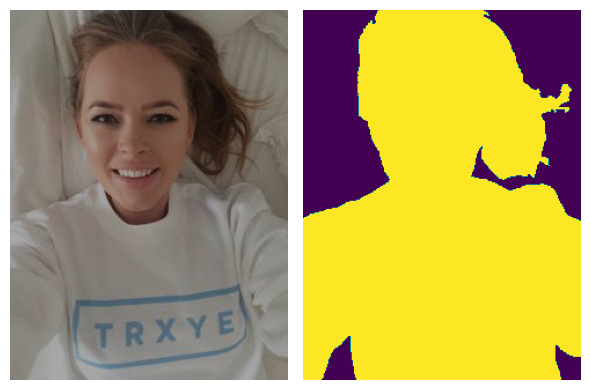

In [8]:
show_idx_image(train_dataset, 0)

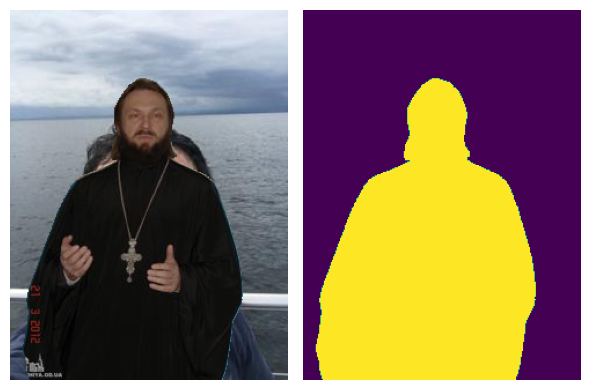

In [9]:
show_idx_image(train_dataset, 50)

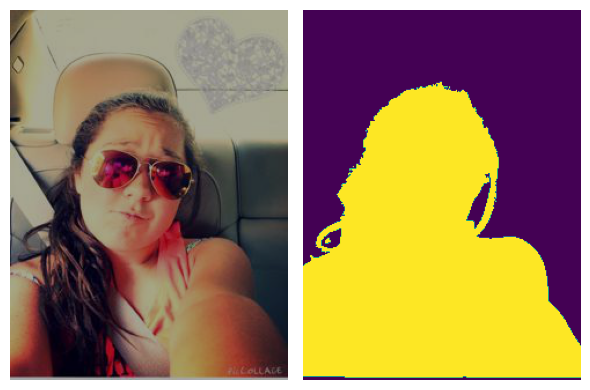

In [10]:
show_idx_image(train_dataset, 53)

## `Загрузчики`

При обучении сети удобнее работать не с датасетами, а с загрузчиками. Загрузчики создаются на основе датасета и позволяют итерироваться по батчам из него.
k
Обратите внимание на параметры `DataLoader`. При `
s`$\;> 1$, батчи готовятся (загружаются картинки, обрабатываются и так далее) сразу в нескольких фоновых процессах. С помощью параметра `shuffle` можно подавать картинки на обучение в случайном порядке.

Обычно, скорость обработки данных на GPU превышает скорость загрузки данных в одном процессе, поэтому типичное значение для `num_workers`$\approx 3\text{-}10$. 

Учтите, что на некоторых системах в Jupyter Notebook при `num_workers`$>0$ `DataLoader` перестаёт работать. В таком случае установите это значение в $0$.

In [11]:
test_data_loader = DataLoader(test_dataset, batch_size=8, num_workers=2)
train_data_loader = DataLoader(train_dataset, batch_size=8, num_workers=2, shuffle=True)

## `DiceLoss (1 балл)`

Функция потерь реализовывается как и все стандартные нейронные модули в pytorch, через `torch.nn.Module`. В ячейке ниже вам предлагается реализовать функцию потерь `dice` (аналог меры Жаккарда).

Результат **Dice Loss** определим как:

$$
\text{Dice Coefficient} = 2\frac{|A \cap B| }{|A| + |B|} \leadsto \text{Dice Loss} = 1 - \frac{2\sum\limits_{i, j}a_{ij}b_{ij}}{\sum\limits_{ij}(a_{ij} + b_{ij} + \varepsilon)}
$$

где $a_{ij} \in [0, 1]$ — предсказанная вероятность нахождения человека в пикселе изображения, $b_{ij}$ — истинная разметка для пикселя изображения.

In [10]:
class DiceLoss(torch.nn.Module):
    def __init__(self, eps=1e-7, reduction=None, with_logits=True):
        """
        Arguments
        ---------
        eps : float
            eps in denominator
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of elements in the batch
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits
        
    def forward(self, logits, true_labels):
        """
        Arguments
        ---------
        logits: torch.Tensor
            Unnormalized probability of true class. Shape: [B, ...]
        true_labels: torch.Tensor
            Mask of correct predictions. Shape: [B, ...]
        Returns
        -------
        torch.Tensor
            If reduction is 'mean' or 'sum' returns a tensor with a single element
            Otherwise, returns a tensor of shape [B]
        """
        true_labels = true_labels.to(torch.long)
        
        if self.with_logits:
            logits = torch.sigmoid(logits)
        
        dice_loss = 1 - 2 * (logits * true_labels).sum(dim=(1, 2)) / (logits + true_labels + self.eps).sum(dim=(1, 2))
        
        if self.reduction == 'sum':
            loss_value = dice_loss.sum()
        elif self.reduction == 'mean':
            loss_value = dice_loss.mean()
        elif self.reduction is None:
            loss_value = dice_loss
            
        return loss_value

Проверка реализации:

In [13]:
logits = torch.tensor([
    [[0, 0.5], [0.5, 1]],
    [[0.1, 0.1], [0, 0]],
])

target = torch.tensor([
    [[0, 1], [1, 1]],
    [[1, 0], [0, 1]],
])

losses = DiceLoss(with_logits=False, reduction=None, eps=1e-7)(logits, target)
npt.assert_almost_equal(losses.numpy(), np.array([0.2, 0.90909]), decimal=4)

loss = DiceLoss(with_logits=False, reduction='mean', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 0.554545, decimal=4)

loss = DiceLoss(with_logits=False, reduction='sum', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 1.10909, decimal=4)

## `U-Net (3 балла)`

Для решения задачи сегментации будем использовать [U-Net](https://arxiv.org/pdf/1505.04597.pdf) с энкодером из первых блоков предобученного `VGG13`.

Концептуальная схема представлена на диаграмме ниже:

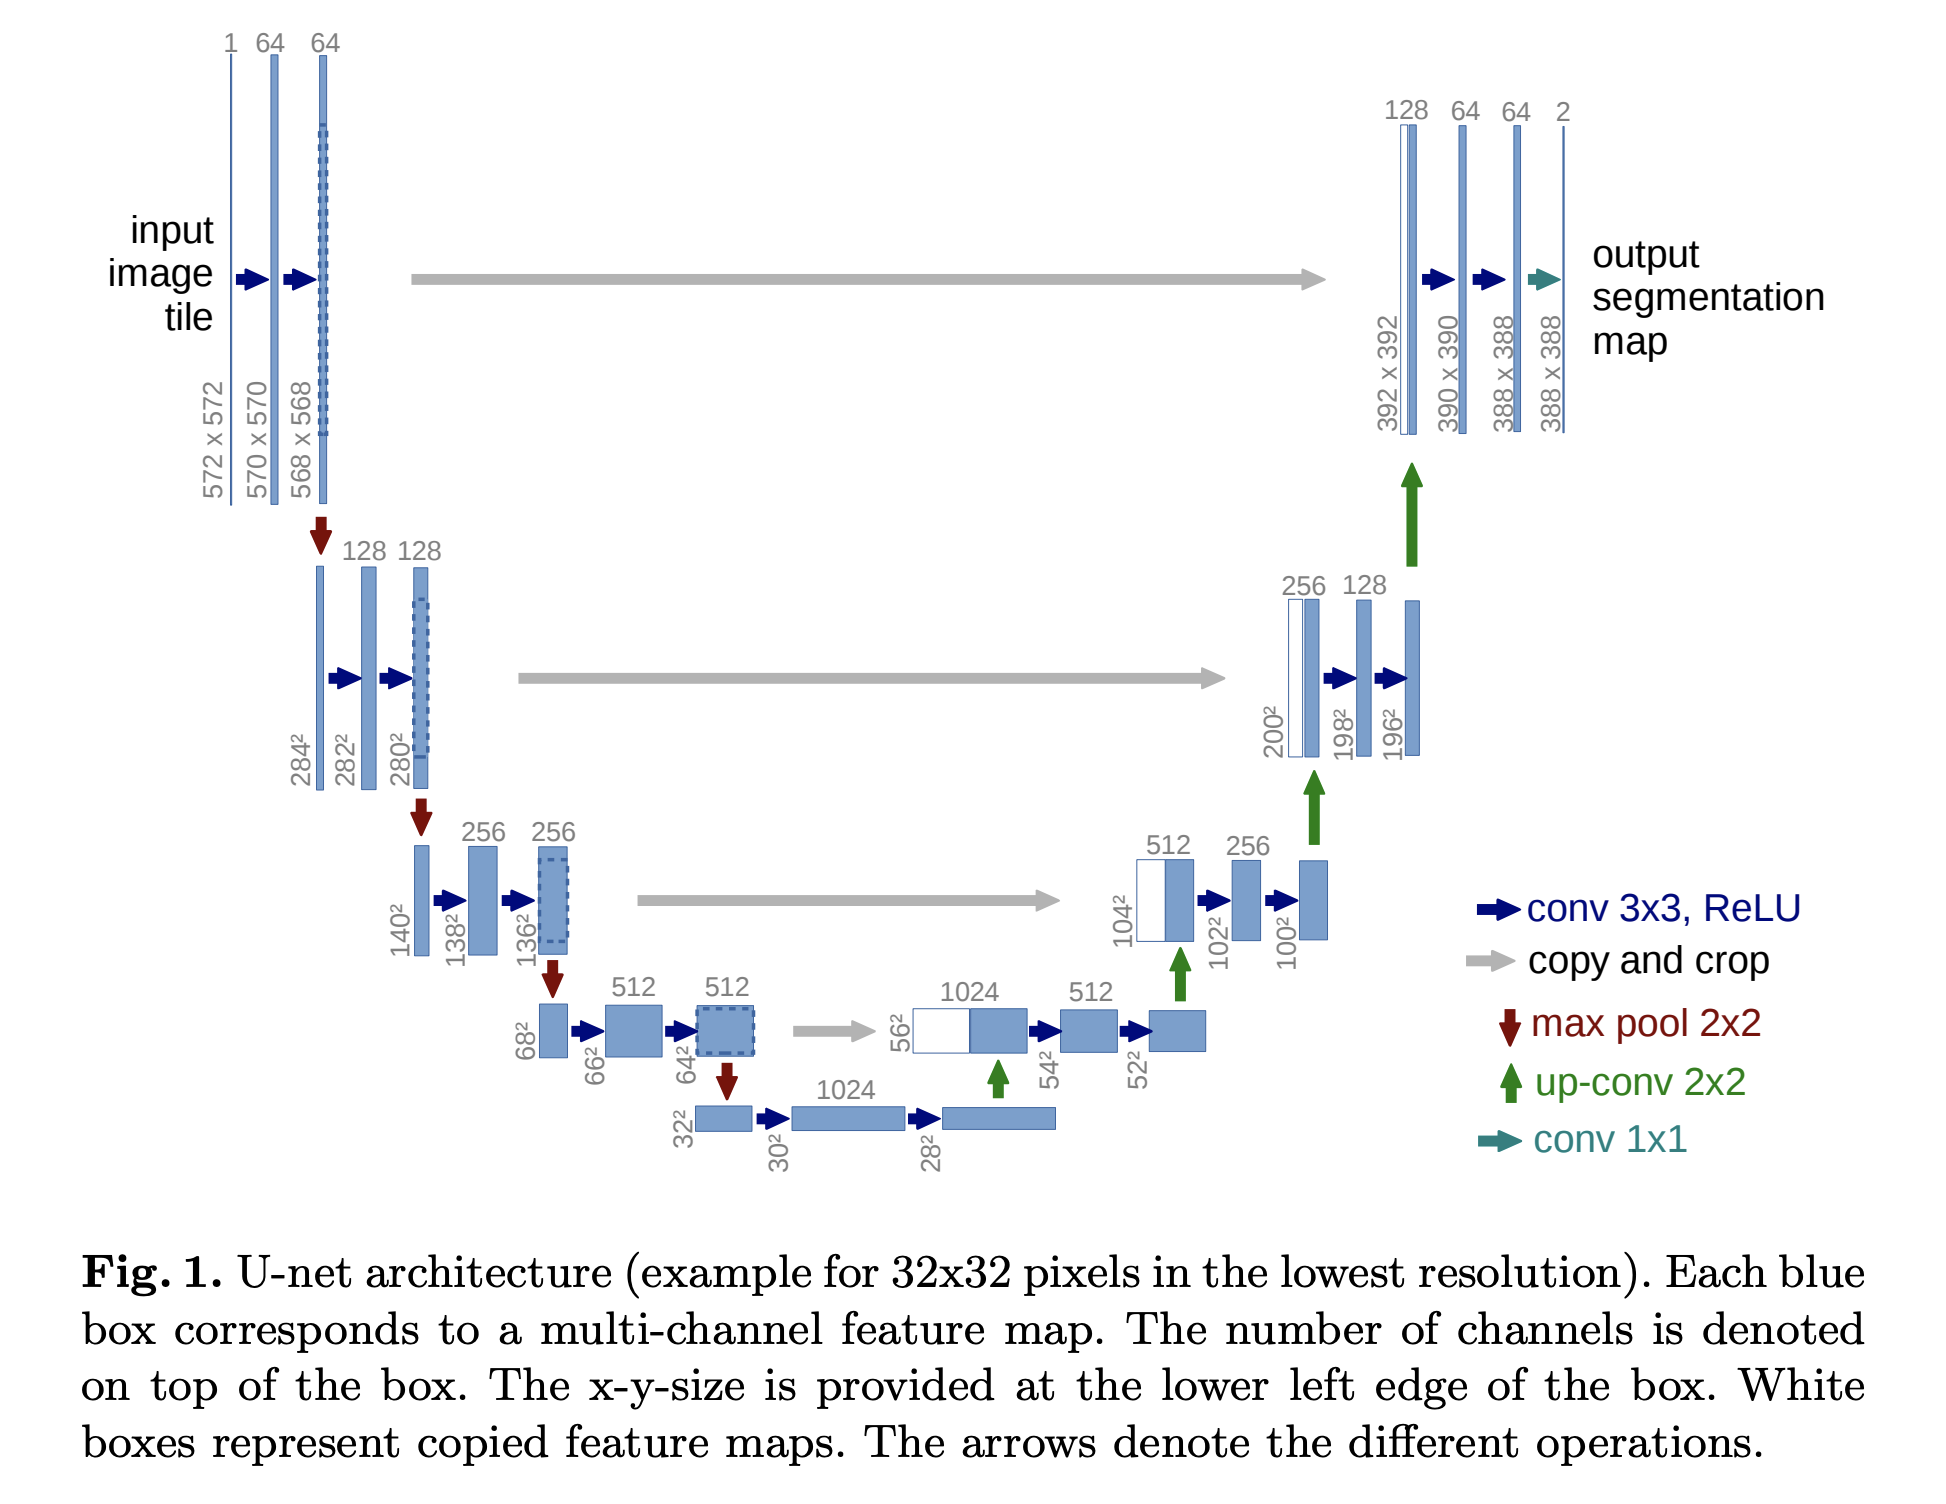

Заметим, что блоки VGG13 имеют следующий вид:
```python
    (0): Conv2d(...)
    (1): ReLU(...)
    (2): Conv2d(...)
    (3): ReLU(...)
    (4): MaxPool2d(...)
```

Для удобства, уберём слои `MaxPool2d` из блоков энкодера и будем применять pooling отдельно.

Реализуйте архитектуру данной сети.

#### `Encoder`

In [11]:
class VGG13Encoder(torch.nn.Module):
    def __init__(self, num_blocks, weights=VGG13_Weights.DEFAULT):
        super().__init__()
        self.num_blocks = num_blocks
        
        # Будем использовать предобученную VGG13 в качестве backbone
        feature_extractor = vgg13(weights=weights).features
        
        # Каждый блок энкодера U-Net — это блок VGG13 без MaxPool2d
        self.blocks = torch.nn.ModuleList()
        for idx in range(self.num_blocks):
            # Возьмите нужные слои из `feature_extractor` для очередного U-Net блока
            # Объедините их с помощью `torch.nn.Sequential`
            self.blocks.append(torch.nn.Sequential(feature_extractor[5 * idx:5 * idx + 4]))

    def forward(self, x):
        activations = []
        for idx, block in enumerate(self.blocks):
            # Примените очередной блок U-Net
            x = self.blocks[idx](x)

            # Сохраните активации для передачи их в декодер
            activations.append(x)

            # При необходимости примените max-pool
            # Можно использовать `torch.functional.F.max_pool2d`
            if idx != len(self.blocks) - 1:
                x = torch.functional.F.max_pool2d(x, kernel_size=2, stride=2, 
                                            padding=0, dilation=1, ceil_mode=False)
            
        return activations

In [15]:
assert sum((param.numel() for param in VGG13Encoder(num_blocks=1).parameters())) == 38720
assert sum((param.numel() for param in VGG13Encoder(num_blocks=2).parameters())) == 260160
assert sum((param.numel() for param in VGG13Encoder(num_blocks=3).parameters())) == 1145408

x = torch.arange(1 * 3 * 320 * 240).reshape(1, 3, 320, 240) / (1 * 3 * 320 * 240)
out = VGG13Encoder(num_blocks=3)(x)

assert len(out) == 3
npt.assert_almost_equal(torch.linalg.norm(out[0]).item(), 902.218, decimal=3)
npt.assert_almost_equal(torch.linalg.norm(out[1]).item(), 571.030, decimal=3)
npt.assert_almost_equal(torch.linalg.norm(out[2]).item(), 648.068, decimal=3)

Downloading: "https://download.pytorch.org/models/vgg13-19584684.pth" to /root/.cache/torch/hub/checkpoints/vgg13-19584684.pth


  0%|          | 0.00/508M [00:00<?, ?B/s]

#### `Decoder`

In [12]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = torch.nn.ReLU()
        
    def forward(self, down, left):
        # Upsample x2 и свёртка
        x = self.upconv(torch.nn.functional.interpolate(down, scale_factor=2))
        
        # Конкатенация выхода энкодера и предыдущего блока декодера
        x = torch.concatenate([left, x], axis=1)
        
        # Две свёртки с ReLu
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))

        return x

In [13]:
class Decoder(torch.nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        self.blocks = torch.nn.ModuleList()
        for idx in range(num_blocks):
            self.blocks.insert(0, DecoderBlock(num_filters * 2 ** idx))

    def forward(self, acts):
        up = acts[-1]
        for block, left in zip(self.blocks, acts[-2::-1]):
            up = block(up, left)
        return up

#### `U-Net`

In [14]:
class UNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks)
        self.decoder = Decoder(64, num_blocks - 1)
        
        # Свёртка 1x1 для попиксельной агрегации каналов
        self.final = torch.nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        return self.final(self.decoder(self.encoder(x)))

In [19]:
model = UNet(num_classes=1, num_blocks=3)
x = torch.arange(1 * 3 * 320 * 240).reshape(1, 3, 320, 240) / (1 * 3 * 320 * 240)

assert sum((param.numel() for param in model.parameters())) == 2067649
assert list(model(x).shape) == [1, 1, 320, 240]
model

UNet(
  (encoder): VGG13Encoder(
    (blocks): ModuleList(
      (0): Sequential(
        (0): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU(inplace=True)
        )
      )
      (1): Sequential(
        (0): Sequential(
          (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (6): ReLU(inplace=True)
          (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (8): ReLU(inplace=True)
        )
      )
      (2): Sequential(
        (0): Sequential(
          (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (11): ReLU(inplace=True)
          (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (13): ReLU(inplace=True)
        )
      )
    )
  )
  (decoder): Decoder(
    (blocks

### `Оценивание качества сети`


Обычно, оптимизируемый функционал сложно интерпретировать, а так же в разных экспериментах могут использоваться разные функции потерь. Поэтому необходимо замерять и отслеживать независимую метрику качества. Предлагается использовать **IoU (Intersection over Union)** — один из стандартных вариантов для задачи сегментации:
$$
\text{IoU} = \frac{|A \cap B|}{|A \cup B|} = \frac{\sum\limits_{ij}a_{ij}b_{ij}}{\sum\limits_{ij}a_{ij} + b_{ij} - a_{ij}b_{ij}}
$$

In [15]:
class IoUScore(torch.nn.Module):
    def __init__(self, threshold, reduction=None, eps=1e-7):
        """
        Arguments
        ---------
        threshold : float
            threshold for logits binarization
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of elements in the batch
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        
        self.threshold = threshold
        self.reduction = reduction
        self.eps = eps
        
    @torch.no_grad()
    def forward(self, logits, true_labels):
        """
        Arguments
        ---------
        logits: torch.Tensor
            Unnormalized probability of true class. Shape: [B, ...]
        true_labels: torch.Tensor
            Mask of correct predictions. Shape: [B, ...]
        Returns
        -------
        torch.Tensor
            If reduction is 'mean' or 'sum' returns a tensor with a single element
            Otherwise, returns a tensor of shape [B]
        """
        logits = logits > self.threshold
        score = (logits * true_labels).sum(dim=(1, 2)) / (logits + true_labels - logits * true_labels + self.eps).sum(dim=(1, 2))
        
        if self.reduction == 'sum':
            score = score.sum()
        elif self.reduction == 'mean':
            score = score.mean()
            
        return score

In [21]:
logits = torch.tensor([
    [
        [0.3089,  0.4311, -0.9711],
        [0.9030,  1.0325, -0.7607],
        [0.9648, -0.5528, -1.1010]
    ], [
        [0.8906,  0.8099,  0.4458],
        [2.6215, -1.3198,  0.3142],
        [0.2262, -0.9175, -0.0174]
    ], [
        [0.8906,  0.8099,  0.4458],
        [2.6215, -1.3198,  0.3142],
        [0.2262, -0.9175, -0.0174]
    ]
])
true_labels = torch.tensor([
    [
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.]
    ], [
        [1., 1., 1.],
        [1., 0., 1.],
        [1., 0., 0.]
    ], [
        [1., 1., 1.],
        [0., 1., 1.],
        [1., 1., 1.]
    ]
])

scores = IoUScore(0.0)(logits, true_labels)
npt.assert_almost_equal(scores.numpy(), np.array([0.3333, 1.0000, 0.5556]), decimal=4)

score = IoUScore(0.0, reduction='sum')(logits, true_labels)
npt.assert_almost_equal(score.item(), 1.8889, decimal=4)

score = IoUScore(0.0, reduction='mean')(logits, true_labels)
npt.assert_almost_equal(score.item(), 0.6296, decimal=4)

### `Tensorboard и логирование`

Для отслеживания процесса обучения обычно требуется сохранять информацию разных его аспектах.

Для полного контроля над процессом обучения обычно требуется сохранять информацию о разных статистиках. Самыми очевидными являются:
1. Значение функции потерь (лосса) на обучающей и тестовой выборках
2. Метики качества, например, **Dice Coefficient** и **IoU (Intersection over Union)** на обучающей и тестовой выборках

Однако, суррогатные метрики могут не отражать реального качества. Поэтому для моделей, которые выдают визуализируемый результат, обычно логируют предсказания для некоторых объектов выборки. В задаче сегментации естественным вариантом является логирование четвёрки: исходное изображение, истинная маска, маска вероятностей истинного класса, бинаризованная маска. 

*Замечание:* лосс и качество на обучающей выборке обычно логируют не только в конце каждой эпохи, но и по отдельным батчам на каждой итерации.

3. Чтобы отслеживать динамику обучения необходимо зафиксировать небольшой набор объектов обучающей и тестовой выборок и после каждой эпохи обучения логировать указанные четыре картинки для каждого объекта.

*Замечание:* можно логировать четвёрки изображений независимо, однако, удобнее объединить их на одной [фигуре](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_figure). Дополнительный плюс — возможность подписать значения метрик для этого объекта в заголовке изображения или добавить colorbar для более простой интерпретации предсказанной маски.

Для удобной категоризации экспериментов обычно в начале обучения сохраняют:

4. [Гиперпараметры модели](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_hparams) 
5. [Структуру модели](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_graph)

Для исследования технических особенностей обучения полезно логировать следующие статистики:

6. [Распределение весов, активаций, градиентов](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_histogram). Сохранять гистограммы каждого параметра после каждой итерации может быть вычислительно неэффективно, поэтому обычно сохраняют распределения весов для каждого отдельного слоя нейронной сети после каждой эпохи. 
7. Норма весов и норма градиента на каждой итерации

Наконец, после каждой эпохи можно визуализировать промежуточные представления входных данных:

8. Активации после каждого слоя/блока, как изображения
9. Градиенты функции потерь по активациям для некоторых объектов обучающей выборки, как изображения

*Замечание:* для реализации пунктов 8, 9 менять код модели не требуется. Используйте хуки: [register_full_backward_hook](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook), [register_forward_hook](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_forward_hook).

При реализации цикла обучения необходимо сохранять метрики $1\text{-}9$ с использованием модуля [torch.utils.tensorboard](https://pytorch.org/docs/stable/tensorboard.html). Файлы с логами, а также чекпоинты весов модели после итерации с наилучшим валидационным качеством (смотрите [torch.save](https://pytorch.org/docs/stable/generated/torch.save.html) и [torch.nn.Module.state_dict](https://pytorch.org/tutorials/recipes/recipes/what_is_state_dict.html)) для **ВСЕХ** проведённых экспериментов (за исключением упавших, недосчитанных и так далее) необходимо сдать в anytask.

### `Эксперименты`

Теперь применим сеть на практике!

Обучите сеть на обучающей выборке и протестируйте качество на тестовой выборке. 

Сначала при обучении используйте только кросс-энтропию (`torch.nn.BCEWithLogitsLoss` будет более удобна для бинарного случая). Зафиксируйте результат.

Сравните между собой несколько стратегий оптимизации:
1. Только кросс-энтропия
2. Только dice loss
3. Сумма двух лоссов с весами (попробуйте $3\text{-} 4$ разных соотношения)

**Для всех экспериментов отобразите графики функции потерь и качества за время обучения. Выведите получившиеся маски для нескольких изображений из датасета. Сделайте выводы.**

Параметры для обучения были взяты с семинара.

In [16]:
import tqdm

num_epoch = 20
lr = 1e-4
weight_decay = 1e-4

step_size = 50
gamma = 0.5
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [25]:
os.makedirs('/kaggle/working/checkpoints', exist_ok=True)
os.makedirs('/kaggle/working/runs', exist_ok=True)

In [26]:
from torch.utils.tensorboard import SummaryWriter

In [18]:
from scipy.special import expit

def show_set_img(model, dataset, idx):
    image, mask = dataset[idx]
    pred = model(image[None,].to(device)).detach()

    image = image.permute(1, 2, 0).numpy()
    image = (image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image = np.clip(image, 0, 1)

    mask = mask.squeeze(0).numpy()
    pred = pred.cpu().squeeze().numpy()

    fig, axes = plt.subplots(1, 4, figsize=(6, 4))
    
    axes[0].set_title('Input image')
    axes[0].imshow(image)
    axes[1].set_title('Mask of input image')
    axes[1].imshow(mask)
    im = axes[2].set_title('Predict probs')
    axes[2].imshow(expit(pred))
    
    axes[3].set_title('Predict mask')
    axes[3].imshow((pred > 0).astype(int))
    
    axes[0].set_axis_off()
    axes[1].set_axis_off()
    axes[2].set_axis_off()
    axes[3].set_axis_off()
    
    fig.tight_layout()
    return fig

In [28]:
def val(epoch, name, model, criterion, metric, val_loss, val_metric, wrt):
    model.eval()
    model = model.to(device)
    
    total_loss, total_metric, n = 0.0, 0.0, 0
    with torch.no_grad():
        for inputs, labels in test_data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            mtr = metric(outputs, labels)
            
            n += outputs.shape[0]
            total_loss += loss.item() * outputs.shape[0]
            total_metric += mtr.item() * outputs.shape[0]
            
    print(f'Val loss for epoch {epoch}: {total_loss / n}')
    val_loss.append(total_loss / n)
    print(f'Val metric for epoch {epoch}: {total_metric / n}')
    
    wrt.add_scalar('val loss', total_loss / n, epoch + 1)
    wrt.add_scalar('val metric', total_metric / n, epoch + 1)
    
    val_metric.append(total_metric / n)

In [29]:
from functools import partial

def plot_mask(orig, mask):
    orig = orig.permute(1, 2, 0).numpy()
    orig = (orig * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    orig = np.clip(orig, 0, 1)
    
    mask = mask.squeeze(0).numpy()
    
    fig, ax = plt.subplots(1, 2, figsize=(6, 4))
    ax[0].imshow(orig)
    ax[1].imshow(mask)
    
    ax[0].set_axis_off()
    ax[1].set_axis_off()
    
    fig.tight_layout()
    return fig


def train(model, name_model, criterion, metric, train_loss, val_loss, train_metric, val_metric,
          wrt):
    model = model.to(device)
    
    for epoch in tqdm.tqdm(range(num_epoch)):
        total_loss, total_metric, n = 0.0, 0.0, 0
        model.train()
        for inputs, labels in train_data_loader:
            optimizer.zero_grad()
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            mtr = metric(outputs, labels)
            loss.backward()
            optimizer.step()
            
            n += outputs.shape[0]
            total_loss += loss.item() * outputs.shape[0]
            total_metric += mtr.item() * outputs.shape[0]
        scheduler.step()
        
        # save activations
        activations = dict()
        # источник: https://gist.github.com/Tushar-N/680633ec18f5cb4b47933da7d10902af
        def save_activations(name, model, input_1, output_1):
            if name in activations:
                activations[name].append(output_1.detach().cpu())
            else:
                activations[name] = [output_1.detach().cpu()]
        
        handels = []
        for name, m in model.named_modules():
            if ('decoder.blocks.' in name or 'encoder.blocks.' in name) and \
               len('decoder.blocks.') + 1 == len(name):
                    handels.append(m.register_forward_hook(partial(save_activations, name)))
        
        output = model(next(iter(train_data_loader))[0].to(device))
        
        for name, m in activations.items():
            wrt.add_histogram("activations " + name, m[0], epoch + 1)
            
            
        for h in handels:
            h.remove()
            
        # plot mask channel
        activations = dict()
        handels = []
        for name, m in model.named_modules():
            if ('decoder.blocks.' in name or 'encoder.blocks.' in name) and \
               len('decoder.blocks.') + 1 == len(name):
                handels.append(m.register_forward_hook(partial(save_activations, name)))
        
        output = model(test_dataset[44][0][None,].to(device))
        
        for name, m in activations.items():
            wrt.add_figure("activations mask " + name, 
                           plot_mask(test_dataset[44][0], m[0][0][0]), 
                           epoch + 1)
        
        for h in handels:
            h.remove()
            
        # save gradients
        grads = dict()
        def save_grads(name, model, input_1, output_1):
            if name in grads:
                grads[name].append(output_1[0].detach().cpu())
            else:
                grads[name] = [output_1[0].detach().cpu()]
        
        handels = []
        for name, m in model.named_modules():
            if ('decoder.blocks.' in name or 'encoder.blocks.' in name) and \
               len('decoder.blocks.') + 1 == len(name):
                    handels.append(m.register_backward_hook(partial(save_grads, name)))
        
        tmp1, tmp2 = next(iter(train_data_loader))
        output = criterion(model(tmp1.to(device)), tmp2.to(device))
        output.backward()
        
        sum = 0
        for name, m in grads.items():
            wrt.add_histogram("grads " + name, m[0], epoch + 1)
            sum += (m[0] ** 2).sum().item()
        wrt.add_scalar('activation gradient norm:', np.sqrt(sum), epoch + 1)
            
        for h in handels:
            h.remove()
        
        # plot mask channel
        grads = dict()
        handels = []
        for name, m in model.named_modules():
            if ('decoder.blocks.' in name or 'encoder.blocks.' in name) and \
               len('decoder.blocks.') + 1 == len(name):
                    handels.append(m.register_backward_hook(partial(save_grads, name)))
        
        tmp1, tmp2 = test_dataset[44]
        tmp1 = tmp1[None,]
        tmp2 = tmp2[None,]
        output = criterion(model(tmp1.to(device)), tmp2.to(device))
        output.backward()
        
        for name, m in grads.items():
            wrt.add_figure("grads mask " + name, 
                           plot_mask(test_dataset[44][0], m[0][0][0]), 
                           epoch + 1)
        
        for h in handels:
            h.remove()
            
        # weights distribution and weight norm
        sum = 0
        for name, m in model.named_modules():
            if type(m) == torch.nn.Conv2d:
                wrt.add_histogram("weights " + name, m.weight.detach().cpu(), epoch + 1)
                sum += (m.weight.detach().cpu() ** 2).sum().item()
        wrt.add_scalar('weights norm:', np.sqrt(sum), epoch + 1)
        
        print(f'Train loss for epoch {epoch}: {total_loss / n}')
        train_loss.append(total_loss / n)
        print(f'Train metric for epoch {epoch}: {total_metric / n}')
        wrt.add_scalar('train loss', total_loss / n, epoch + 1)
        wrt.add_scalar('train metric', total_metric / n, epoch + 1)
        wrt.add_figure('prediction set', show_set_img(model, test_dataset, 44), epoch + 1)
        train_metric.append(total_metric / n)
        torch.save(model.state_dict(), '/kaggle/working/checkpoints/' + name_model + '_' + str(epoch + 1) +'epoch_train.pth')
        
        val(epoch, name_model, model, criterion, metric, val_loss, val_metric, wrt)


## **Кросс-энтропия**

In [30]:
model = UNet()
criterion_CE = torch.nn.BCEWithLogitsLoss()
metric = IoUScore(threshold=0, reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [31]:
wrt = SummaryWriter("runs/UNET_CE_exp")
train_loss_CE_U, val_loss_CE_U, train_metric_CE_U, val_metric_CE_U = [], [], [], []
train(model, 'UNET_CE_exp', criterion_CE, metric, train_loss_CE_U, val_loss_CE_U, train_metric_CE_U, val_metric_CE_U, 
      wrt)

wrt.add_hparams({'model': 'UNet', 'loss': 'BCE Loss'}, {'IoU': max(val_metric_CE_U)})
wrt.add_graph(model, train_dataset[50][0][None,].to(device))

wrt.close()


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

TensorBoard 2.11.2 at http://0.0.0.0:6060/ (Press CTRL+C to quit)
  0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1113: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Train loss for epoch 0: 0.459700597303885
Train metric for epoch 0: 0.691466004230358


  5%|▌         | 1/20 [01:25<26:56, 85.09s/it]

Val loss for epoch 0: 0.3138209934352983
Val metric for epoch 0: 0.7508913418079944
Train loss for epoch 1: 0.3839305618074205
Train metric for epoch 1: 0.7133023158709209


 10%|█         | 2/20 [02:47<24:58, 83.25s/it]

Val loss for epoch 1: 0.35939127840894336
Val metric for epoch 1: 0.6971545308194262
Train loss for epoch 2: 0.33246863195189724
Train metric for epoch 2: 0.7318200068120603


 15%|█▌        | 3/20 [04:09<23:25, 82.66s/it]

Val loss for epoch 2: 0.2581060138788629
Val metric for epoch 2: 0.7853543745710495
Train loss for epoch 3: 0.3106504578943606
Train metric for epoch 3: 0.7505868717476174


 20%|██        | 4/20 [05:31<22:01, 82.58s/it]

Val loss for epoch 3: 0.2833817125634944
Val metric for epoch 3: 0.782102699820877
Train loss for epoch 4: 0.3089993147496824
Train metric for epoch 4: 0.754301606990673


 25%|██▌       | 5/20 [06:53<20:34, 82.33s/it]

Val loss for epoch 4: 0.253642350540939
Val metric for epoch 4: 0.768325704632076
Train loss for epoch 5: 0.2736669698467961
Train metric for epoch 5: 0.7653966059508147


 30%|███       | 6/20 [08:15<19:11, 82.27s/it]

Val loss for epoch 5: 0.26108554534032835
Val metric for epoch 5: 0.7665337721506754
Train loss for epoch 6: 0.274794791230449
Train metric for epoch 6: 0.766940778096517


 35%|███▌      | 7/20 [09:38<17:54, 82.65s/it]

Val loss for epoch 6: 0.23630737677110847
Val metric for epoch 6: 0.7727944018147516
Train loss for epoch 7: 0.2559005913028011
Train metric for epoch 7: 0.7757927502526177


 40%|████      | 8/20 [11:00<16:28, 82.36s/it]

Val loss for epoch 7: 0.3430447701021289
Val metric for epoch 7: 0.6937580205870013
Train loss for epoch 8: 0.27018669415403296
Train metric for epoch 8: 0.7731114077568054


 45%|████▌     | 9/20 [12:23<15:05, 82.35s/it]

Val loss for epoch 8: 0.22297369598919617
Val metric for epoch 8: 0.7900158986977651
Train loss for epoch 9: 0.25682442066846073
Train metric for epoch 9: 0.7765132999420166


 50%|█████     | 10/20 [13:45<13:43, 82.35s/it]

Val loss for epoch 9: 0.21937790132583457
Val metric for epoch 9: 0.7991407420618314
Train loss for epoch 10: 0.2644705770633839
Train metric for epoch 10: 0.7662415969813312


 55%|█████▌    | 11/20 [15:07<12:21, 82.34s/it]

Val loss for epoch 10: 0.26259350892922556
Val metric for epoch 10: 0.7869310518528553
Train loss for epoch 11: 0.25011304210733487
Train metric for epoch 11: 0.7839487771634702


 60%|██████    | 12/20 [16:30<10:59, 82.39s/it]

Val loss for epoch 11: 0.23130793668699604
Val metric for epoch 11: 0.8151804441255881
Train loss for epoch 12: 0.23087491925115938
Train metric for epoch 12: 0.7891719883459586


 65%|██████▌   | 13/20 [17:52<09:35, 82.28s/it]

Val loss for epoch 12: 0.2029798561376883
Val metric for epoch 12: 0.8115559621905604
Train loss for epoch 13: 0.23038197992024598
Train metric for epoch 13: 0.7976011640937241


 70%|███████   | 14/20 [19:14<08:13, 82.20s/it]

Val loss for epoch 13: 0.23356837404112443
Val metric for epoch 13: 0.8140448090877939
Train loss for epoch 14: 0.23548556252762123
Train metric for epoch 14: 0.7889888267163877


 75%|███████▌  | 15/20 [20:36<06:51, 82.20s/it]

Val loss for epoch 14: 0.24044174558304726
Val metric for epoch 14: 0.7920940810061515
Train loss for epoch 15: 0.24107675656124397
Train metric for epoch 15: 0.7809299962608902


 80%|████████  | 16/20 [21:58<05:28, 82.17s/it]

Val loss for epoch 15: 0.23793152608770005
Val metric for epoch 15: 0.7711445101609467
Train loss for epoch 16: 0.2393982418488573
Train metric for epoch 16: 0.780708863735199


 85%|████████▌ | 17/20 [23:20<04:06, 82.10s/it]

Val loss for epoch 16: 0.2158907211207329
Val metric for epoch 16: 0.8019313955983371
Train loss for epoch 17: 0.2414819049835205
Train metric for epoch 17: 0.7880141211439062


 90%|█████████ | 18/20 [24:42<02:44, 82.10s/it]

Val loss for epoch 17: 0.20676639972003638
Val metric for epoch 17: 0.8013756537268347
Train loss for epoch 18: 0.23360175455058063
Train metric for epoch 18: 0.7919229687584771


 95%|█████████▌| 19/20 [26:04<01:21, 81.97s/it]

Val loss for epoch 18: 0.20778978187987146
Val metric for epoch 18: 0.806755117068054
Train loss for epoch 19: 0.22092960607122492
Train metric for epoch 19: 0.7949640348222521


100%|██████████| 20/20 [27:26<00:00, 82.31s/it]

Val loss for epoch 19: 0.26752198482236117
Val metric for epoch 19: 0.7842608601488965


In [32]:
def plot_result(model, loss, train_loss, val_loss, train_metric, val_metric):
   plt.subplots(1, 2, figsize=(14,5))
   plt.suptitle(model)
   plt.subplot(1, 2, 1)
   plt.plot(train_loss)
   plt.plot(val_loss)
   plt.xlabel('Эпоха')
   plt.ylabel(loss)
   plt.legend(['Train', 'Val'])
   plt.grid()

   plt.subplot(1, 2, 2)
   plt.plot(train_metric)
   plt.plot(val_metric)
   plt.xlabel('Эпоха')
   plt.ylabel('IoUScore')
   plt.legend(['Train', 'Val'])
   plt.grid()
   plt.show()

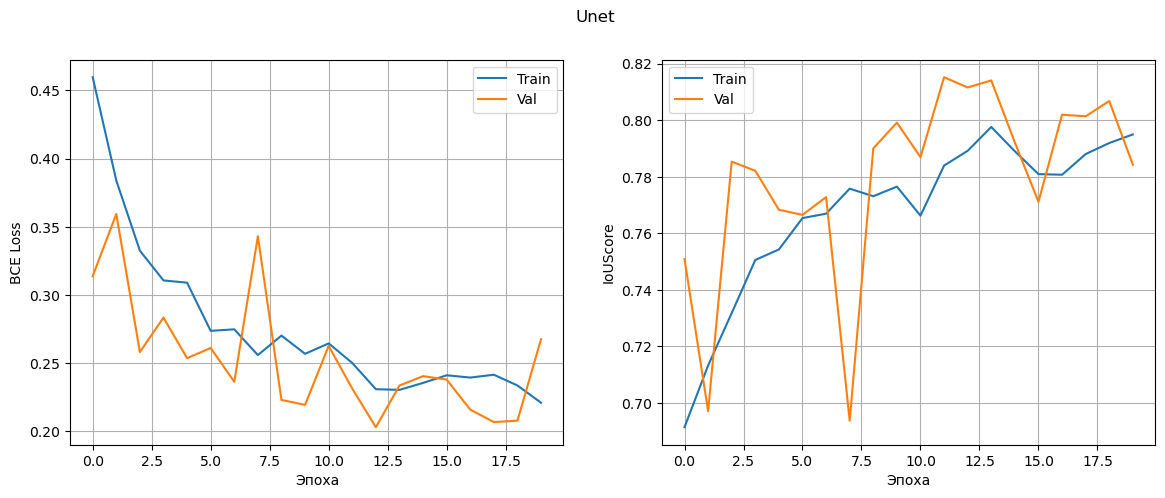

In [33]:
plot_result('Unet', 'BCE Loss', train_loss_CE_U, val_loss_CE_U, train_metric_CE_U, val_metric_CE_U)

Обучение происходило на Kaggle, векторные графики не отображались, поэтому в данном ноутбуке представлены растровые графики :(

Лучшее значение IOUscore на валидации на 12ой эпохе.

## **Dice Loss**

In [34]:
model = UNet()
criterion_DL = DiceLoss(reduction='mean')
metric = IoUScore(threshold=0, reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [35]:
wrt = SummaryWriter("runs/UNET_DL_exp")
train_loss_DL_U, val_loss_DL_U, train_metric_DL_U, val_metric_DL_U = [], [], [], []
train(model, 'UNET_DL_exp', criterion_DL, metric, train_loss_DL_U, val_loss_DL_U, train_metric_DL_U, val_metric_DL_U, 
      wrt)

wrt.add_hparams({'model': 'UNet', 'loss': 'Dice Loss'}, {'IoU': max(val_metric_DL_U)})
wrt.add_graph(model, train_dataset[50][0][None,].to(device))

wrt.close()

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss for epoch 0: 0.31403237868238376
Train metric for epoch 0: 0.617169670782966


  5%|▌         | 1/20 [01:15<24:01, 75.87s/it]

Val loss for epoch 0: 0.3031524052011206
Val metric for epoch 0: 0.6039797169096927
Train loss for epoch 1: 0.29497120415722883
Train metric for epoch 1: 0.6407841568522983


 10%|█         | 2/20 [02:31<22:48, 76.00s/it]

Val loss for epoch 1: 0.3031524052011206
Val metric for epoch 1: 0.6039797169096927
Train loss for epoch 2: 0.2922681110435062
Train metric for epoch 2: 0.6420659102333917


 15%|█▌        | 3/20 [03:48<21:39, 76.44s/it]

Val loss for epoch 2: 0.3031524052011206
Val metric for epoch 2: 0.6039797169096927
Train loss for epoch 3: 0.2920016415693142
Train metric for epoch 3: 0.6443518113206934


 20%|██        | 4/20 [05:05<20:24, 76.54s/it]

Val loss for epoch 3: 0.30315240097384083
Val metric for epoch 3: 0.6039797169096927
Train loss for epoch 4: 0.30308692817334776
Train metric for epoch 4: 0.6352881458070543


 25%|██▌       | 5/20 [06:23<19:16, 77.11s/it]

Val loss for epoch 4: 0.3031527871358479
Val metric for epoch 4: 0.6039797169096927
Train loss for epoch 5: 0.2873273592966574
Train metric for epoch 5: 0.6464337262400874


 30%|███       | 6/20 [07:41<18:03, 77.39s/it]

Val loss for epoch 5: 0.301652396401615
Val metric for epoch 5: 0.6063701417429227
Train loss for epoch 6: 0.29078461254084553
Train metric for epoch 6: 0.6443333953398246


 35%|███▌      | 7/20 [08:58<16:43, 77.18s/it]

Val loss for epoch 6: 0.30315240097384083
Val metric for epoch 6: 0.6039797169096927
Train loss for epoch 7: 0.29739173151828624
Train metric for epoch 7: 0.6398477088080512


 40%|████      | 8/20 [10:15<15:27, 77.28s/it]

Val loss for epoch 7: 0.3031506424254559
Val metric for epoch 7: 0.6039797169096927
Train loss for epoch 8: 0.2995335399221491
Train metric for epoch 8: 0.6364154685868157


 45%|████▌     | 9/20 [11:33<14:10, 77.28s/it]

Val loss for epoch 8: 0.3031523301669046
Val metric for epoch 8: 0.6039797169096927
Train loss for epoch 9: 0.2935685728214405
Train metric for epoch 9: 0.640489169579965


 50%|█████     | 10/20 [12:51<12:55, 77.57s/it]

Val loss for epoch 9: 0.3031476140022278
Val metric for epoch 9: 0.6039797169096927
Train loss for epoch 10: 0.2877841344586125
Train metric for epoch 10: 0.6484225055023476


 55%|█████▌    | 11/20 [14:07<11:34, 77.15s/it]

Val loss for epoch 10: 0.303152249425861
Val metric for epoch 10: 0.6039797169096927
Train loss for epoch 11: 0.2962278502296518
Train metric for epoch 11: 0.6387888879246182


 60%|██████    | 12/20 [15:24<10:15, 76.98s/it]

Val loss for epoch 11: 0.30315211013699256
Val metric for epoch 11: 0.6039797169096927
Train loss for epoch 12: 0.2979367890622881
Train metric for epoch 12: 0.6372963307080446


 65%|██████▌   | 13/20 [16:41<08:59, 77.12s/it]

Val loss for epoch 12: 0.30315036913181875
Val metric for epoch 12: 0.6039797169096927
Train loss for epoch 13: 0.294923749588154
Train metric for epoch 13: 0.6399009016708092


 70%|███████   | 14/20 [17:58<07:42, 77.14s/it]

Val loss for epoch 13: 0.3031366822567392
Val metric for epoch 13: 0.6039797169096927
Train loss for epoch 14: 0.29560490007753726
Train metric for epoch 14: 0.6391261806311431


 75%|███████▌  | 15/20 [19:16<06:26, 77.33s/it]

Val loss for epoch 14: 0.294128140659197
Val metric for epoch 14: 0.6205183690321361
Train loss for epoch 15: 0.28598581194877626
Train metric for epoch 15: 0.6513374471664428


 80%|████████  | 16/20 [20:37<05:13, 78.25s/it]

Val loss for epoch 15: 0.2813652612216084
Val metric for epoch 15: 0.6357276164893563
Train loss for epoch 16: 0.28749919282065495
Train metric for epoch 16: 0.6531057283613417


 85%|████████▌ | 17/20 [21:53<03:53, 77.82s/it]

Val loss for epoch 16: 0.2903252034745318
Val metric for epoch 16: 0.6210958103761606
Train loss for epoch 17: 0.28926855471399093
Train metric for epoch 17: 0.6498843080467648


 90%|█████████ | 18/20 [23:11<02:35, 77.70s/it]

Val loss for epoch 17: 0.26187883063833767
Val metric for epoch 17: 0.6575511748909105
Train loss for epoch 18: 0.2740444485787992
Train metric for epoch 18: 0.6667493187056648


 95%|█████████▌| 19/20 [24:28<01:17, 77.47s/it]

Val loss for epoch 18: 0.25909637094389465
Val metric for epoch 18: 0.6614065618379742
Train loss for epoch 19: 0.2784076179398431
Train metric for epoch 19: 0.6607047272611547


100%|██████████| 20/20 [25:44<00:00, 77.25s/it]

Val loss for epoch 19: 0.25442875224225064
Val metric for epoch 19: 0.666261522482473


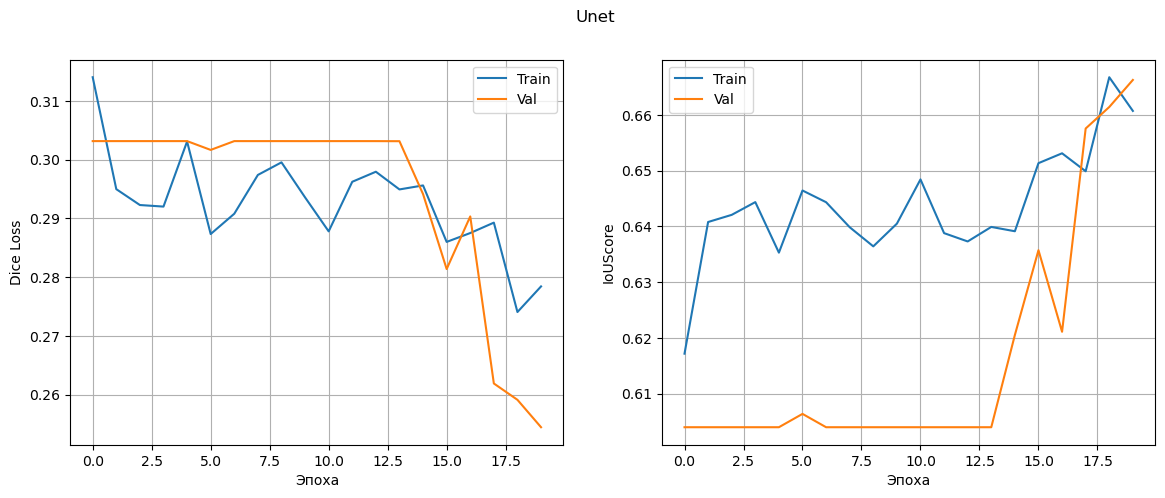

In [36]:
plot_result('Unet', 'Dice Loss', train_loss_DL_U, val_loss_DL_U, train_metric_DL_U, val_metric_DL_U)

Лучшее значение IOUscore на валидации на 20ой эпохе.

## **Сумма лоссов с весами**

In [37]:
criterion_CE = torch.nn.BCEWithLogitsLoss()
criterion_DL = DiceLoss(reduction='mean')

def sum_loss(out, labels, coeff1, coeff2, criterion_CE, criterion_DL):
    return coeff1 * criterion_CE(out, labels) + coeff2 * criterion_DL(out, labels)

In [38]:
from functools import partial
coeff = [(0.25, 0.75), (0.5, 0.5), (0.75, 0.25)]
train_loss_U, val_loss_U, train_metric_U, val_metric_U = dict(), dict(), dict(), dict()

for (i, (a, b)) in enumerate(coeff):
    model = UNet()
    criterion = partial(sum_loss, coeff1=a, coeff2=b, criterion_CE=criterion_CE, criterion_DL=criterion_DL)
    metric = IoUScore(threshold=0, reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    wrt = SummaryWriter('runs/UNET_exp_' + str(i + 1))
    train_loss_U[i], val_loss_U[i], train_metric_U[i], val_metric_U[i] = [], [], [], []
    train(model, 'UNET_exp_' + str(i + 1), criterion, metric, train_loss_U[i], val_loss_U[i], train_metric_U[i], val_metric_U[i], wrt)
    
    wrt.add_hparams({'model': 'UNet', 'loss': str (a) + ' * BCE + ' + str(b) + ' * DL'}, {'IoU': max(val_metric_U[i])})
    wrt.add_graph(model, train_dataset[50][0][None,].to(device))

    wrt.close()

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss for epoch 0: 0.3325585358231156
Train metric for epoch 0: 0.7012805847768431


  5%|▌         | 1/20 [01:22<26:02, 82.26s/it]

Val loss for epoch 0: 0.2946498639194678
Val metric for epoch 0: 0.726730021601873
Train loss for epoch 1: 0.2737165634720414
Train metric for epoch 1: 0.7454977084972241


 10%|█         | 2/20 [02:45<24:45, 82.55s/it]

Val loss for epoch 1: 0.25218999998789304
Val metric for epoch 1: 0.7608173113342718
Train loss for epoch 2: 0.2529055784366749
Train metric for epoch 2: 0.7673146414756775


 15%|█▌        | 3/20 [04:08<23:29, 82.92s/it]

Val loss for epoch 2: 0.21026395007650903
Val metric for epoch 2: 0.7806818421850813
Train loss for epoch 3: 0.25047195977634856
Train metric for epoch 3: 0.7692145659305432


 20%|██        | 4/20 [05:30<22:03, 82.75s/it]

Val loss for epoch 3: 0.17936567740237458
Val metric for epoch 3: 0.8158143915183155
Train loss for epoch 4: 0.2423399617936876
Train metric for epoch 4: 0.7746919986936781


 25%|██▌       | 5/20 [06:55<20:50, 83.39s/it]

Val loss for epoch 4: 0.18244521119070392
Val metric for epoch 4: 0.8150683307478613
Train loss for epoch 5: 0.23394993080033197
Train metric for epoch 5: 0.7840458649176139


 30%|███       | 6/20 [08:18<19:24, 83.15s/it]

Val loss for epoch 5: 0.19072930546517067
Val metric for epoch 5: 0.8074715657437102
Train loss for epoch 6: 0.22159690607477117
Train metric for epoch 6: 0.7910326314855505


 35%|███▌      | 7/20 [09:40<17:57, 82.91s/it]

Val loss for epoch 6: 0.17830270761293723
Val metric for epoch 6: 0.8161718126729871
Train loss for epoch 7: 0.22200077690460063
Train metric for epoch 7: 0.7853317153012311


 40%|████      | 8/20 [11:03<16:34, 82.90s/it]

Val loss for epoch 7: 0.1718026194589358
Val metric for epoch 7: 0.8227458431365642
Train loss for epoch 8: 0.22240536937007196
Train metric for epoch 8: 0.7906221078943323


 45%|████▌     | 9/20 [12:26<15:11, 82.87s/it]

Val loss for epoch 8: 0.18391307448664457
Val metric for epoch 8: 0.8237309574235415
Train loss for epoch 9: 0.2160305521664796
Train metric for epoch 9: 0.7943842637980426


 50%|█████     | 10/20 [13:48<13:47, 82.74s/it]

Val loss for epoch 9: 0.21636159432695268
Val metric for epoch 9: 0.782650406901718
Train loss for epoch 10: 0.2256530342720173
Train metric for epoch 10: 0.7890924603850753


 55%|█████▌    | 11/20 [15:10<12:23, 82.61s/it]

Val loss for epoch 10: 0.1850947009544846
Val metric for epoch 10: 0.811046689114672
Train loss for epoch 11: 0.21805384719813312
Train metric for epoch 11: 0.7935196538324709


 60%|██████    | 12/20 [16:33<11:01, 82.67s/it]

Val loss for epoch 11: 0.16219085233008607
Val metric for epoch 11: 0.8279134931293786
Train loss for epoch 12: 0.2064474074266575
Train metric for epoch 12: 0.8027181174136975


 65%|██████▌   | 13/20 [17:56<09:37, 82.57s/it]

Val loss for epoch 12: 0.19612740223289382
Val metric for epoch 12: 0.8101003170013428
Train loss for epoch 13: 0.20616604659292434
Train metric for epoch 13: 0.8026806215886716


 70%|███████   | 14/20 [19:18<08:14, 82.50s/it]

Val loss for epoch 13: 0.17862299887846547
Val metric for epoch 13: 0.8245947052401008
Train loss for epoch 14: 0.21141454813656985
Train metric for epoch 14: 0.7982507419586181


 75%|███████▌  | 15/20 [20:41<06:53, 82.61s/it]

Val loss for epoch 14: 0.17113046305822144
Val metric for epoch 14: 0.8257598433088749
Train loss for epoch 15: 0.2169571630380772
Train metric for epoch 15: 0.7937755627102322


 80%|████████  | 16/20 [22:03<05:30, 82.62s/it]

Val loss for epoch 15: 0.1740183153896467
Val metric for epoch 15: 0.8203979789787996
Train loss for epoch 16: 0.2017731977171368
Train metric for epoch 16: 0.8041745806623388


 85%|████████▌ | 17/20 [23:27<04:08, 82.82s/it]

Val loss for epoch 16: 0.1597347766795057
Val metric for epoch 16: 0.8358681620435512
Train loss for epoch 17: 0.20742570024949533
Train metric for epoch 17: 0.8038588048793651


 90%|█████████ | 18/20 [24:49<02:45, 82.62s/it]

Val loss for epoch 17: 0.18857684055118695
Val metric for epoch 17: 0.809121273933573
Train loss for epoch 18: 0.2076731961192908
Train metric for epoch 18: 0.7978607879744636


 95%|█████████▌| 19/20 [26:12<01:22, 82.66s/it]

Val loss for epoch 18: 0.16977283717892694
Val metric for epoch 18: 0.825914760007926
Train loss for epoch 19: 0.1968150806427002
Train metric for epoch 19: 0.8093018143265336


100%|██████████| 20/20 [27:34<00:00, 82.72s/it]

Val loss for epoch 19: 0.18127894137345307
Val metric for epoch 19: 0.814184491938733



  0%|          | 0/20 [00:00<?, ?it/s]

Train loss for epoch 0: 0.379245295325915
Train metric for epoch 0: 0.7052122921413846


  5%|▌         | 1/20 [01:23<26:28, 83.61s/it]

Val loss for epoch 0: 0.24726973685389714
Val metric for epoch 0: 0.7745439190391108
Train loss for epoch 1: 0.30979578477365
Train metric for epoch 1: 0.7432058043833132


 10%|█         | 2/20 [02:46<25:00, 83.36s/it]

Val loss for epoch 1: 0.2733034614130115
Val metric for epoch 1: 0.7556168382049452
Train loss for epoch 2: 0.2925448585439611
Train metric for epoch 2: 0.7472508509070785


 15%|█▌        | 3/20 [04:09<23:32, 83.10s/it]

Val loss for epoch 2: 0.23356737534627847
Val metric for epoch 2: 0.7955975207031196
Train loss for epoch 3: 0.2659929628283889
Train metric for epoch 3: 0.766642973334701


 20%|██        | 4/20 [05:35<22:26, 84.16s/it]

Val loss for epoch 3: 0.21380678009479603
Val metric for epoch 3: 0.8018960322894103
Train loss for epoch 4: 0.27027972592247856
Train metric for epoch 4: 0.766893002986908


 25%|██▌       | 5/20 [06:58<20:54, 83.65s/it]

Val loss for epoch 4: 0.2270788740604482
Val metric for epoch 4: 0.7981935786017289
Train loss for epoch 5: 0.2561587471432156
Train metric for epoch 5: 0.7776437617231299


 30%|███       | 6/20 [08:20<19:25, 83.24s/it]

Val loss for epoch 5: 0.2316719759651955
Val metric for epoch 5: 0.7952535490617685
Train loss for epoch 6: 0.2454357147216797
Train metric for epoch 6: 0.7815268946577002


 35%|███▌      | 7/20 [09:43<18:02, 83.29s/it]

Val loss for epoch 6: 0.24127980686248618
Val metric for epoch 6: 0.78921444111682
Train loss for epoch 7: 0.23954195455268576
Train metric for epoch 7: 0.7861295812218277


 40%|████      | 8/20 [11:06<16:38, 83.17s/it]

Val loss for epoch 7: 0.20458206513249283
Val metric for epoch 7: 0.8080339220398707
Train loss for epoch 8: 0.23091042653278068
Train metric for epoch 8: 0.7935738519386009


 45%|████▌     | 9/20 [12:29<15:13, 83.03s/it]

Val loss for epoch 8: 0.20202577980697578
Val metric for epoch 8: 0.8132664650044543
Train loss for epoch 9: 0.2268277986402865
Train metric for epoch 9: 0.7944742258389791


 50%|█████     | 10/20 [13:52<13:48, 82.89s/it]

Val loss for epoch 9: 0.2113479823930889
Val metric for epoch 9: 0.8128246145045503
Train loss for epoch 10: 0.23801879986568733
Train metric for epoch 10: 0.7897002213972586


 55%|█████▌    | 11/20 [15:15<12:28, 83.14s/it]

Val loss for epoch 10: 0.26001900180857235
Val metric for epoch 10: 0.7508701263590062
Train loss for epoch 11: 0.22919088796333031
Train metric for epoch 11: 0.7951362611629345


 60%|██████    | 12/20 [16:38<11:04, 83.03s/it]

Val loss for epoch 11: 0.1975118710216901
Val metric for epoch 11: 0.8215851842934359
Train loss for epoch 12: 0.22140420498671354
Train metric for epoch 12: 0.7947763384713067


 65%|██████▌   | 13/20 [18:01<09:40, 82.95s/it]

Val loss for epoch 12: 0.2133036289654725
Val metric for epoch 12: 0.8004736676283762
Train loss for epoch 13: 0.22077640586429173
Train metric for epoch 13: 0.8003605615651166


 70%|███████   | 14/20 [19:23<08:16, 82.82s/it]

Val loss for epoch 13: 0.20794713623980257
Val metric for epoch 13: 0.8077692786852518
Train loss for epoch 14: 0.23617782723020625
Train metric for epoch 14: 0.7821666323697125


 75%|███████▌  | 15/20 [20:46<06:53, 82.77s/it]

Val loss for epoch 14: 0.19276679735234442
Val metric for epoch 14: 0.8174681540922071
Train loss for epoch 15: 0.21702915377087062
Train metric for epoch 15: 0.7958573226575498


 80%|████████  | 16/20 [22:09<05:31, 82.87s/it]

Val loss for epoch 15: 0.2455874004051195
Val metric for epoch 15: 0.7878940790257556
Train loss for epoch 16: 0.22339150812890796
Train metric for epoch 16: 0.79509831711098


 85%|████████▌ | 17/20 [23:32<04:08, 82.76s/it]

Val loss for epoch 16: 0.1958884078982874
Val metric for epoch 16: 0.8227324232142023
Train loss for epoch 17: 0.22146202522295494
Train metric for epoch 17: 0.8002525478822213


 90%|█████████ | 18/20 [24:54<02:45, 82.66s/it]

Val loss for epoch 17: 0.18262632201749382
Val metric for epoch 17: 0.8240864640432046
Train loss for epoch 18: 0.22884867407657483
Train metric for epoch 18: 0.7846172367201911


 95%|█████████▌| 19/20 [26:16<01:22, 82.56s/it]

Val loss for epoch 18: 0.18531488273160676
Val metric for epoch 18: 0.8213440822371354
Train loss for epoch 19: 0.21708653522862328
Train metric for epoch 19: 0.7985243454685917


100%|██████████| 20/20 [27:39<00:00, 82.98s/it]

Val loss for epoch 19: 0.16617148586198793
Val metric for epoch 19: 0.831502748296616



  0%|          | 0/20 [00:00<?, ?it/s]

Train loss for epoch 0: 0.45969689417768406
Train metric for epoch 0: 0.6749085711549829


  5%|▌         | 1/20 [01:24<26:50, 84.75s/it]

Val loss for epoch 0: 0.3390674231745673
Val metric for epoch 0: 0.7051245122091144
Train loss for epoch 1: 0.36228222970609314
Train metric for epoch 1: 0.71412149588267


 10%|█         | 2/20 [02:47<25:05, 83.64s/it]

Val loss for epoch 1: 0.3061166948883246
Val metric for epoch 1: 0.76270669952352
Train loss for epoch 2: 0.30609918227902166
Train metric for epoch 2: 0.7515312080030088


 15%|█▌        | 3/20 [04:10<23:39, 83.49s/it]

Val loss for epoch 2: 0.22696048222112317
Val metric for epoch 2: 0.7913419308391869
Train loss for epoch 3: 0.291964197423723
Train metric for epoch 3: 0.7578235851393805


 20%|██        | 4/20 [05:33<22:10, 83.18s/it]

Val loss for epoch 3: 0.30900813649732173
Val metric for epoch 3: 0.7418122553656287
Train loss for epoch 4: 0.29421524908807545
Train metric for epoch 4: 0.7542327845538104


 25%|██▌       | 5/20 [06:56<20:46, 83.10s/it]

Val loss for epoch 4: 0.2725301110152657
Val metric for epoch 4: 0.7634556158214596
Train loss for epoch 5: 0.2717309011794903
Train metric for epoch 5: 0.770235407087538


 30%|███       | 6/20 [08:19<19:22, 83.03s/it]

Val loss for epoch 5: 0.21533568594472627
Val metric for epoch 5: 0.7947577440992315
Train loss for epoch 6: 0.2700081105585451
Train metric for epoch 6: 0.7633730843332078


 35%|███▌      | 7/20 [09:42<17:57, 82.92s/it]

Val loss for epoch 6: 0.2046027478385479
Val metric for epoch 6: 0.8123512420248478
Train loss for epoch 7: 0.2720951541044094
Train metric for epoch 7: 0.7706811351246304


 40%|████      | 8/20 [11:05<16:35, 82.98s/it]

Val loss for epoch 7: 0.25541209783537167
Val metric for epoch 7: 0.7721456475291691
Train loss for epoch 8: 0.2529498250616921
Train metric for epoch 8: 0.7770618942048815


 45%|████▌     | 9/20 [12:28<15:13, 83.01s/it]

Val loss for epoch 8: 0.21910841266314188
Val metric for epoch 8: 0.803269550732687
Train loss for epoch 9: 0.2363698301050398
Train metric for epoch 9: 0.7886462804123208


 50%|█████     | 10/20 [13:51<13:51, 83.16s/it]

Val loss for epoch 9: 0.21046446348335726
Val metric for epoch 9: 0.7965505469775369
Train loss for epoch 10: 0.24789344897976628
Train metric for epoch 10: 0.7869773401154412


 55%|█████▌    | 11/20 [15:14<12:28, 83.15s/it]

Val loss for epoch 10: 0.2256661201199741
Val metric for epoch 10: 0.8036899342604563
Train loss for epoch 11: 0.22863905312838378
Train metric for epoch 11: 0.8010371631163138


 60%|██████    | 12/20 [16:38<11:05, 83.18s/it]

Val loss for epoch 11: 0.20423637446782267
Val metric for epoch 11: 0.8191234135458655
Train loss for epoch 12: 0.23082084333455122
Train metric for epoch 12: 0.7897752850143998


 65%|██████▌   | 13/20 [18:01<09:41, 83.08s/it]

Val loss for epoch 12: 0.19804302439199273
Val metric for epoch 12: 0.818920353625683
Train loss for epoch 13: 0.2330179097475829
Train metric for epoch 13: 0.7960125855163291


 70%|███████   | 14/20 [19:28<08:26, 84.44s/it]

Val loss for epoch 13: 0.2419407915139029
Val metric for epoch 13: 0.7994590722922738
Train loss for epoch 14: 0.2286696704449477
Train metric for epoch 14: 0.7937716590033637


 75%|███████▌  | 15/20 [20:51<06:59, 83.98s/it]

Val loss for epoch 14: 0.22025305011593704
Val metric for epoch 14: 0.8218617557633853
Train loss for epoch 15: 0.23721504388032136
Train metric for epoch 15: 0.7889134701093038


 80%|████████  | 16/20 [22:14<05:34, 83.57s/it]

Val loss for epoch 15: 0.29242370589405087
Val metric for epoch 15: 0.7203892892134105
Train loss for epoch 16: 0.23404932134681278
Train metric for epoch 16: 0.7863394111174125


 85%|████████▌ | 17/20 [23:36<04:09, 83.31s/it]

Val loss for epoch 16: 0.2758050290405328
Val metric for epoch 16: 0.7608116421293705
Train loss for epoch 17: 0.22716860267851088
Train metric for epoch 17: 0.8014452588116681


 90%|█████████ | 18/20 [24:59<02:46, 83.08s/it]

Val loss for epoch 17: 0.21754749954169525
Val metric for epoch 17: 0.8072977826950398
Train loss for epoch 18: 0.23897401752295316
Train metric for epoch 18: 0.784086652773398


 95%|█████████▌| 19/20 [26:22<01:23, 83.16s/it]

Val loss for epoch 18: 0.1962504157571928
Val metric for epoch 18: 0.8146898945172628
Train loss for epoch 19: 0.22162439814320317
Train metric for epoch 19: 0.7994813623251739


100%|██████████| 20/20 [27:46<00:00, 83.30s/it]

Val loss for epoch 19: 0.19799824893897308
Val metric for epoch 19: 0.8098827101660113


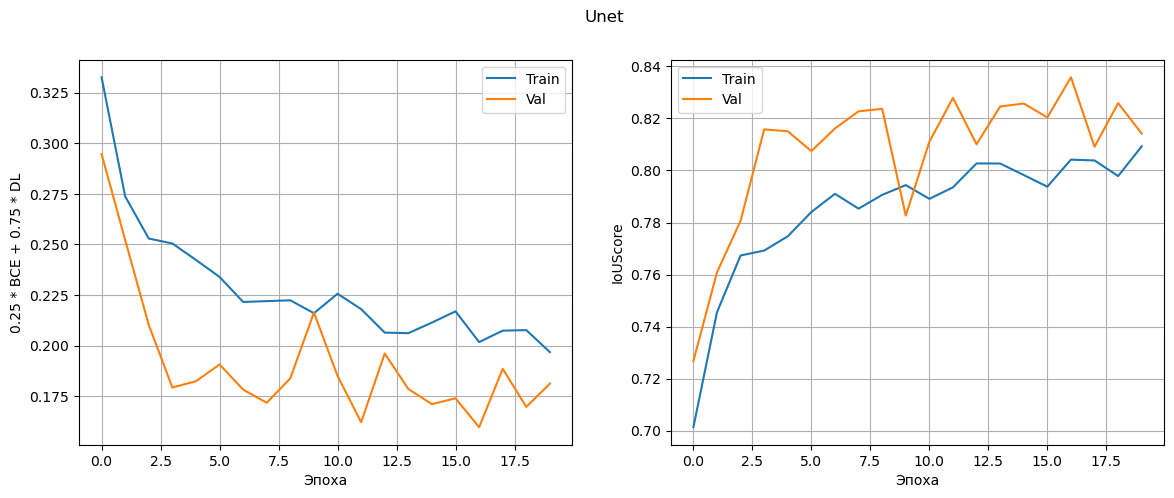

In [39]:
plot_result('Unet', '0.25 * BCE + 0.75 * DL', train_loss_U[0], val_loss_U[0], train_metric_U[0], val_metric_U[0])

Лучшее значение IOUscore на валидации на 17ой эпохе.

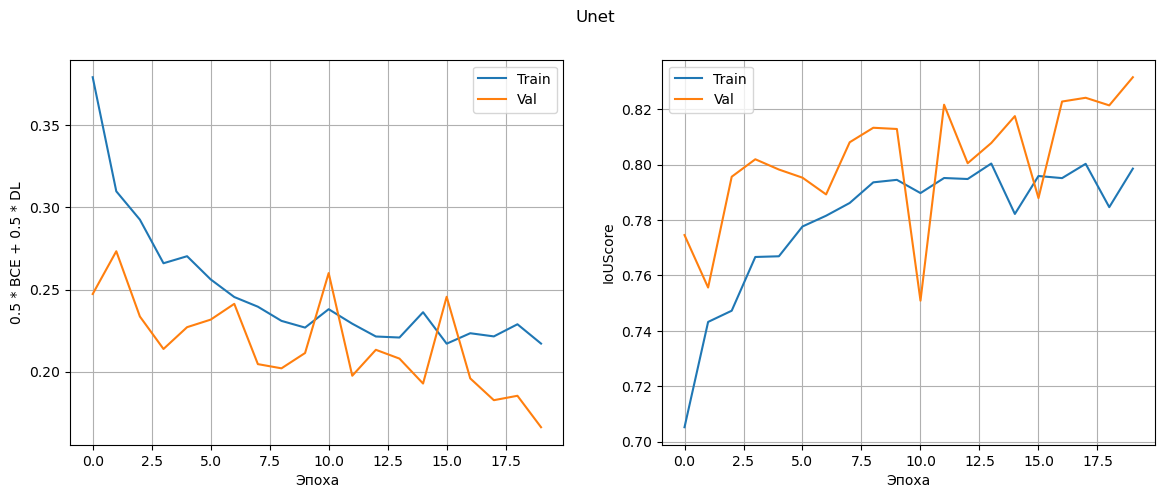

In [40]:
plot_result('Unet', '0.5 * BCE + 0.5 * DL', train_loss_U[1], val_loss_U[1], train_metric_U[1], val_metric_U[1])

Лучшее значение IOUscore на валидации на 20ой эпохе.

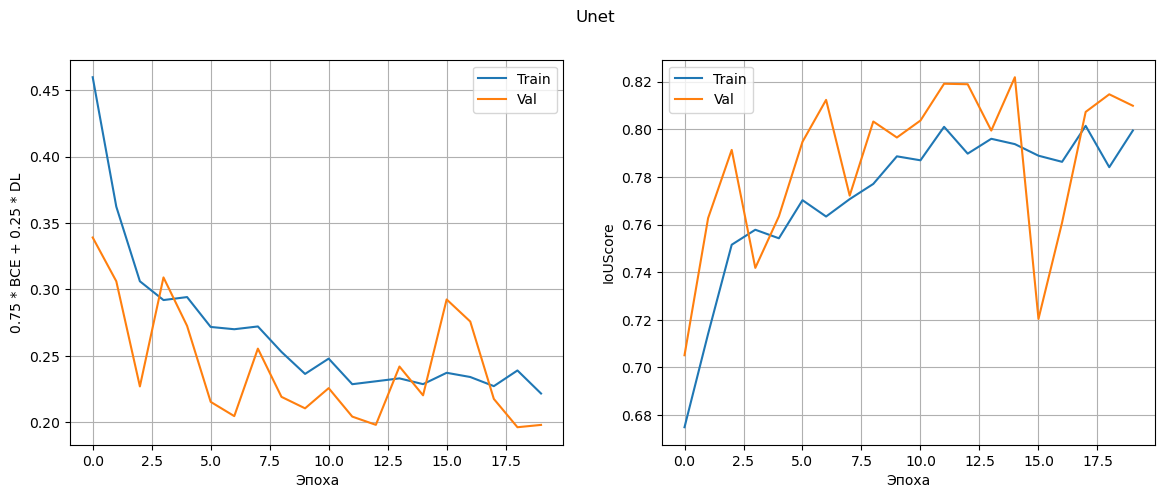

In [41]:
plot_result('Unet', '0.75 * BCE + 0.25 * DL', train_loss_U[2], val_loss_U[2], train_metric_U[2], val_metric_U[2])

Лучшее значение IOUscore на валидации на 15ой эпохе.

## `LinkNet (2 балла)`

Реализуйте архитектуру [LinkNet](https://arxiv.org/pdf/1707.03718.pdf) с использованием энкодера, основанного на `VGG13`. Архитектура похожа на `Unet`, но вместо конкатенации слоёв используются skip-connections. Для реализации достаточно переписать структуру декодировщика из предыдущего пункта.

**Обучите сеть и проведите анализ согласно предыдущему пункту. Сравните LinkNet и U-Net по качеству и скорости работы. Сделайте выводы.**

In [42]:
class DecoderBlockL(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = torch.nn.ReLU()
        
    def forward(self, down, left):
        x = self.upconv(torch.nn.functional.interpolate(down, scale_factor=2))
        x = self.relu(self.conv1(x + left))
        x = self.relu(self.conv2(x))

        return x

In [43]:
class DecoderL(torch.nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        self.blocks = torch.nn.ModuleList()
        for idx in range(num_blocks):
            self.blocks.insert(0, DecoderBlockL(num_filters * 2 ** idx))

    def forward(self, acts):
        up = acts[-1]
        for block, left in zip(self.blocks, acts[-2::-1]):
            up = block(up, left)
        return up

In [44]:
class LinkNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks)
        self.decoder = DecoderL(64, num_blocks - 1)
        
        # Свёртка 1x1 для попиксельной агрегации каналов
        self.final = torch.nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        return self.final(self.decoder(self.encoder(x)))

## **Кросс-энтропия**

In [45]:
model = LinkNet()
criterion_CE = torch.nn.BCEWithLogitsLoss()
metric = IoUScore(threshold=0, reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [46]:
wrt = SummaryWriter("runs/LinkNet_CE_exp")
train_loss_CE_L, val_loss_CE_L, train_metric_CE_L, val_metric_CE_L = [], [], [], []
train(model, 'LinkNet_CE_exp', criterion_CE, metric, train_loss_CE_L, val_loss_CE_L, train_metric_CE_L, val_metric_CE_L, 
      wrt)

wrt.add_hparams({'model': 'LinkNet', 'loss': 'BCE Loss'}, {'IoU': max(val_metric_CE_L)})
wrt.add_graph(model, train_dataset[50][0][None,].to(device))

wrt.close()

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss for epoch 0: 0.44838328317359644
Train metric for epoch 0: 0.6915669293756839


  5%|▌         | 1/20 [01:16<24:16, 76.68s/it]

Val loss for epoch 0: 0.4341733903749615
Val metric for epoch 0: 0.6604562807590404
Train loss for epoch 1: 0.37650528647281506
Train metric for epoch 1: 0.7199519208625511


 10%|█         | 2/20 [02:33<23:02, 76.80s/it]

Val loss for epoch 1: 0.2886896703048801
Val metric for epoch 1: 0.7608886132849023
Train loss for epoch 2: 0.32634914857369884
Train metric for epoch 2: 0.7527358769487451


 15%|█▌        | 3/20 [03:50<21:47, 76.88s/it]

Val loss for epoch 2: 0.3924282782889427
Val metric for epoch 2: 0.6711382003540688
Train loss for epoch 3: 0.29267650615285945
Train metric for epoch 3: 0.7660043289043286


 20%|██        | 4/20 [05:07<20:29, 76.85s/it]

Val loss for epoch 3: 0.24748014516018807
Val metric for epoch 3: 0.7764222930509148
Train loss for epoch 4: 0.28226701394275383
Train metric for epoch 4: 0.7614239622045447


 25%|██▌       | 5/20 [06:24<19:14, 76.97s/it]

Val loss for epoch 4: 0.22641536234118415
Val metric for epoch 4: 0.7942484938506539
Train loss for epoch 5: 0.28942972395155164
Train metric for epoch 5: 0.7575843249426948


 30%|███       | 6/20 [07:41<17:56, 76.87s/it]

Val loss for epoch 5: 0.2357399633801575
Val metric for epoch 5: 0.7970008270960327
Train loss for epoch 6: 0.2694325108439834
Train metric for epoch 6: 0.7694320324615196


 35%|███▌      | 7/20 [08:58<16:40, 76.95s/it]

Val loss for epoch 6: 0.23538325177439562
Val metric for epoch 6: 0.7919254822933928
Train loss for epoch 7: 0.26356196736847914
Train metric for epoch 7: 0.7732047021830524


 40%|████      | 8/20 [10:19<15:40, 78.39s/it]

Val loss for epoch 7: 0.23414983225206956
Val metric for epoch 7: 0.7990109316000702
Train loss for epoch 8: 0.26856344479101674
Train metric for epoch 8: 0.7715518773043597


 45%|████▌     | 9/20 [11:36<14:16, 77.90s/it]

Val loss for epoch 8: 0.2647626226675426
Val metric for epoch 8: 0.7910157945139188
Train loss for epoch 9: 0.25721026831203037
Train metric for epoch 9: 0.780491064566153


 50%|█████     | 10/20 [12:53<12:55, 77.51s/it]

Val loss for epoch 9: 0.2686258385367427
Val metric for epoch 9: 0.7963882959480827
Train loss for epoch 10: 0.2553836136394077
Train metric for epoch 10: 0.7802603260676066


 55%|█████▌    | 11/20 [14:10<11:35, 77.28s/it]

Val loss for epoch 10: 0.2697330096089248
Val metric for epoch 10: 0.7656375486800011
Train loss for epoch 11: 0.24437509033415053
Train metric for epoch 11: 0.7837150581677754


 60%|██████    | 12/20 [15:26<10:16, 77.10s/it]

Val loss for epoch 11: 0.2638906168599501
Val metric for epoch 11: 0.7611796285243745
Train loss for epoch 12: 0.22706766689265215
Train metric for epoch 12: 0.7859899028142293


 65%|██████▌   | 13/20 [16:45<09:02, 77.48s/it]

Val loss for epoch 12: 0.2379415380827924
Val metric for epoch 12: 0.8122495569235889
Train loss for epoch 13: 0.2480991576998322
Train metric for epoch 13: 0.7790517165925768


 70%|███████   | 14/20 [18:01<07:43, 77.30s/it]

Val loss for epoch 13: 0.1907058334942405
Val metric for epoch 13: 0.8220399998603983
Train loss for epoch 14: 0.22238686720530193
Train metric for epoch 14: 0.7885558325273019


 75%|███████▌  | 15/20 [19:18<06:24, 76.98s/it]

Val loss for epoch 14: 0.20097039280631018
Val metric for epoch 14: 0.8222924589265322
Train loss for epoch 15: 0.25465477307637535
Train metric for epoch 15: 0.7842105876957929


 80%|████████  | 16/20 [20:34<05:07, 76.88s/it]

Val loss for epoch 15: 0.21058722199700403
Val metric for epoch 15: 0.8212123906358759
Train loss for epoch 16: 0.23258816003799437
Train metric for epoch 16: 0.7910766932699416


 85%|████████▌ | 17/20 [21:51<03:50, 76.80s/it]

Val loss for epoch 16: 0.25668007864597
Val metric for epoch 16: 0.7681010707895807
Train loss for epoch 17: 0.23436739961306255
Train metric for epoch 17: 0.7924691353020845


 90%|█████████ | 18/20 [23:08<02:33, 76.94s/it]

Val loss for epoch 17: 0.2527459794325186
Val metric for epoch 17: 0.778695875871266
Train loss for epoch 18: 0.2413420197257289
Train metric for epoch 18: 0.7875900060159189


 95%|█████████▌| 19/20 [24:25<01:16, 76.99s/it]

Val loss for epoch 18: 0.26730874159657364
Val metric for epoch 18: 0.8029667870372745
Train loss for epoch 19: 0.23361127383179134
Train metric for epoch 19: 0.7876358990316038


100%|██████████| 20/20 [25:42<00:00, 77.13s/it]

Val loss for epoch 19: 0.23028046125215842
Val metric for epoch 19: 0.8113248834373258


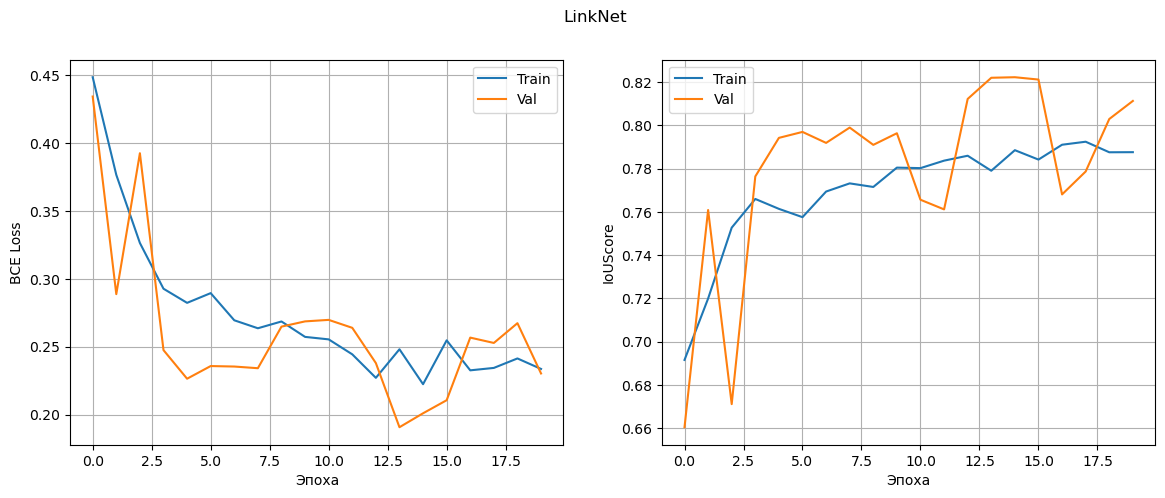

In [47]:
plot_result('LinkNet', 'BCE Loss', train_loss_CE_L, val_loss_CE_L, train_metric_CE_L, val_metric_CE_L)

Лучшее значение IOUscore на валидации на 15ой эпохе.

## **Dice Loss**

In [48]:
model = LinkNet()
criterion_DL = DiceLoss(reduction='mean')
metric = IoUScore(threshold=0, reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [49]:
wrt = SummaryWriter("runs/LinkNet_DL_exp")
train_loss_DL_L, val_loss_DL_L, train_metric_DL_L, val_metric_DL_L = [], [], [], []
train(model, 'LinkNet_DL_exp', criterion_DL, metric, train_loss_DL_L, val_loss_DL_L, train_metric_DL_L, val_metric_DL_L, wrt)

wrt.add_hparams({'model': 'LinkNet', 'loss': 'Dice Loss'}, {'IoU': max(val_metric_DL_L)})
wrt.add_graph(model, train_dataset[50][0][None,].to(device))

wrt.close()

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss for epoch 0: 0.3012070155143738
Train metric for epoch 0: 0.640913852320777


  5%|▌         | 1/20 [01:10<22:22, 70.64s/it]

Val loss for epoch 0: 0.3031524052011206
Val metric for epoch 0: 0.6039797169096927
Train loss for epoch 1: 0.29055505209498933
Train metric for epoch 1: 0.6442792656686571


 10%|█         | 2/20 [02:20<21:08, 70.47s/it]

Val loss for epoch 1: 0.3031524052011206
Val metric for epoch 1: 0.6039797169096927
Train loss for epoch 2: 0.2935247063195264
Train metric for epoch 2: 0.6406842551407991


 15%|█▌        | 3/20 [03:31<20:02, 70.71s/it]

Val loss for epoch 2: 0.3031524052011206
Val metric for epoch 2: 0.6039797169096927
Train loss for epoch 3: 0.2936709533355854
Train metric for epoch 3: 0.6413920834329393


 20%|██        | 4/20 [04:45<19:10, 71.91s/it]

Val loss for epoch 3: 0.30315256668320784
Val metric for epoch 3: 0.6039797169096927
Train loss for epoch 4: 0.3017897621790568
Train metric for epoch 4: 0.632403686399813


 25%|██▌       | 5/20 [05:58<18:02, 72.20s/it]

Val loss for epoch 4: 0.30315305620220534
Val metric for epoch 4: 0.6039797169096927
Train loss for epoch 5: 0.2896539043276398
Train metric for epoch 5: 0.6462988922331068


 30%|███       | 6/20 [07:10<16:51, 72.26s/it]

Val loss for epoch 5: 0.3031238110352915
Val metric for epoch 5: 0.6039797169096927
Train loss for epoch 6: 0.29627896587053937
Train metric for epoch 6: 0.6378507028685676


 35%|███▌      | 7/20 [08:22<15:36, 72.07s/it]

Val loss for epoch 6: 0.30315240351020867
Val metric for epoch 6: 0.6039797169096927
Train loss for epoch 7: 0.2972774331216459
Train metric for epoch 7: 0.636580851342943


 40%|████      | 8/20 [09:34<14:24, 72.01s/it]

Val loss for epoch 7: 0.3030853586416718
Val metric for epoch 7: 0.6039797169096927
Train loss for epoch 8: 0.2883235471116172
Train metric for epoch 8: 0.6491438496554339


 45%|████▌     | 9/20 [10:44<13:07, 71.55s/it]

Val loss for epoch 8: 0.27300460277296973
Val metric for epoch 8: 0.6431757803504349
Train loss for epoch 9: 0.2796159721745385
Train metric for epoch 9: 0.6603281510317767


 50%|█████     | 10/20 [11:57<11:59, 71.91s/it]

Val loss for epoch 9: 0.2727031072614886
Val metric for epoch 9: 0.6390053405829356
Train loss for epoch 10: 0.2729435048500697
Train metric for epoch 10: 0.6662496811372263


 55%|█████▌    | 11/20 [13:09<10:47, 71.90s/it]

Val loss for epoch 10: 0.26388486860491706
Val metric for epoch 10: 0.6534023120048198
Train loss for epoch 11: 0.271667171827069
Train metric for epoch 11: 0.6686881050357112


 60%|██████    | 12/20 [14:21<09:34, 71.86s/it]

Val loss for epoch 11: 0.2466871260751224
Val metric for epoch 11: 0.6753825853902398
Train loss for epoch 12: 0.26852323759485175
Train metric for epoch 12: 0.6723225679220977


 65%|██████▌   | 13/20 [15:34<08:25, 72.14s/it]

Val loss for epoch 12: 0.2409753012107619
Val metric for epoch 12: 0.6821374774824643
Train loss for epoch 13: 0.25644134850413713
Train metric for epoch 13: 0.6864172377409758


 70%|███████   | 14/20 [16:45<07:11, 71.89s/it]

Val loss for epoch 13: 0.23247481491548797
Val metric for epoch 13: 0.6948234751714882
Train loss for epoch 14: 0.2558348970722269
Train metric for epoch 14: 0.6891583806497079


 75%|███████▌  | 15/20 [17:57<05:59, 71.86s/it]

Val loss for epoch 14: 0.23211801495957882
Val metric for epoch 14: 0.6951340914618039
Train loss for epoch 15: 0.25419656082435893
Train metric for epoch 15: 0.6930396360821194


 80%|████████  | 16/20 [19:09<04:47, 71.85s/it]

Val loss for epoch 15: 0.22311508106001726
Val metric for epoch 15: 0.706052544269156
Train loss for epoch 16: 0.2511993759429013
Train metric for epoch 16: 0.6955422419088858


 85%|████████▌ | 17/20 [20:21<03:35, 71.93s/it]

Val loss for epoch 16: 0.2106560338684853
Val metric for epoch 16: 0.7218850618558572
Train loss for epoch 17: 0.24439700852941584
Train metric for epoch 17: 0.7053540857632955


 90%|█████████ | 18/20 [21:32<02:23, 71.84s/it]

Val loss for epoch 17: 0.21942040049437936
Val metric for epoch 17: 0.7092725871302558
Train loss for epoch 18: 0.2300443505137055
Train metric for epoch 18: 0.7208762296923885


 95%|█████████▌| 19/20 [22:45<01:12, 72.07s/it]

Val loss for epoch 18: 0.21794551906856238
Val metric for epoch 18: 0.7098060440509877
Train loss for epoch 19: 0.23935023846449677
Train metric for epoch 19: 0.7123759617628874


100%|██████████| 20/20 [23:57<00:00, 71.89s/it]

Val loss for epoch 19: 0.2061649553530605
Val metric for epoch 19: 0.727596104990506


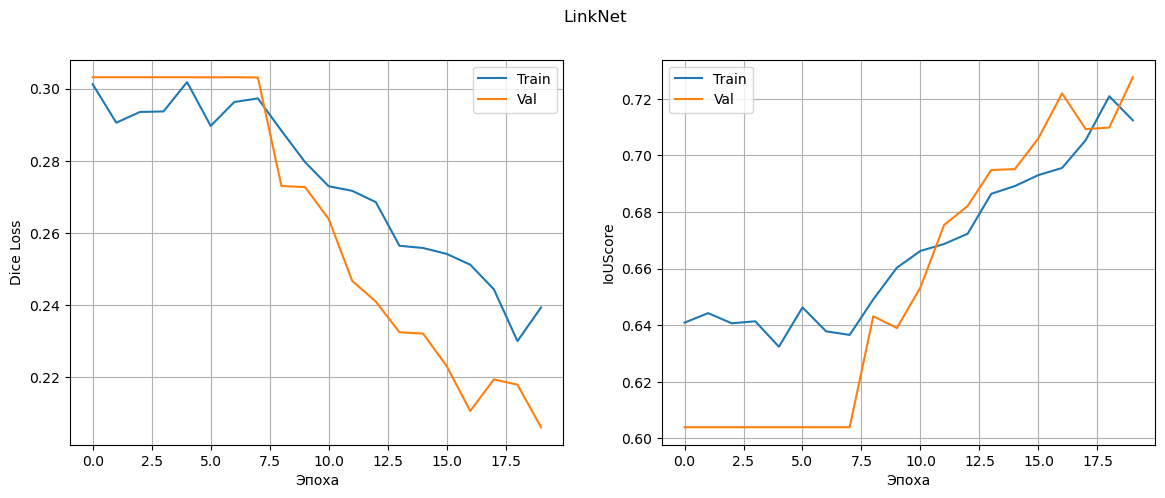

In [50]:
plot_result('LinkNet', 'Dice Loss', train_loss_DL_L, val_loss_DL_L, train_metric_DL_L, val_metric_DL_L)

Лучшее значение IOUscore на валидации на 20ой эпохе.

## **Сумма лоссов с коэффициентами**

In [51]:
train_loss_L, val_loss_L, train_metric_L, val_metric_L = dict(), dict(), dict(), dict()

for (i, (a, b)) in enumerate(coeff):
    model = LinkNet()
    criterion = partial(sum_loss, coeff1=a, coeff2=b, criterion_CE=criterion_CE, criterion_DL=criterion_DL)
    metric = IoUScore(threshold=0, reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    wrt = SummaryWriter('runs/LinkNet_exp_' + str(i + 1))
    train_loss_L[i], val_loss_L[i], train_metric_L[i], val_metric_L[i] = [], [], [], []
    train(model, 'LinkNet_exp_' + str(i + 1), criterion, metric, train_loss_L[i], val_loss_L[i], train_metric_L[i], val_metric_L[i], wrt)
    
    wrt.add_hparams({'model': 'LinkNet', 'loss': str (a) + ' * BCE + ' + str(b) + ' * DL'}, {'IoU': max(val_metric_L[i])})
    wrt.add_graph(model, train_dataset[50][0][None,].to(device))

    wrt.close()

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss for epoch 0: 0.3468146820421572
Train metric for epoch 0: 0.6968442049732915


  5%|▌         | 1/20 [01:17<24:28, 77.26s/it]

Val loss for epoch 0: 0.25482213465457265
Val metric for epoch 0: 0.7596489474283042
Train loss for epoch 1: 0.2758574946500637
Train metric for epoch 1: 0.746320416574125


 10%|█         | 2/20 [02:37<23:44, 79.14s/it]

Val loss for epoch 1: 0.21814400803112816
Val metric for epoch 1: 0.7829784340892277
Train loss for epoch 2: 0.25454911746360637
Train metric for epoch 2: 0.7609091798464457


 15%|█▌        | 3/20 [03:54<22:08, 78.12s/it]

Val loss for epoch 2: 0.22095025959589804
Val metric for epoch 2: 0.8003980995070005
Train loss for epoch 3: 0.25570420190140053
Train metric for epoch 3: 0.7636506063849837


 20%|██        | 4/20 [05:11<20:42, 77.67s/it]

Val loss for epoch 3: 0.2022825518609784
Val metric for epoch 3: 0.7993753493254911
Train loss for epoch 4: 0.2379618427488539
Train metric for epoch 4: 0.7768106578897547


 25%|██▌       | 5/20 [06:28<19:19, 77.31s/it]

Val loss for epoch 4: 0.19026270255129388
Val metric for epoch 4: 0.8140350318124109
Train loss for epoch 5: 0.22705400367577872
Train metric for epoch 5: 0.7867062123616536


 30%|███       | 6/20 [07:45<18:00, 77.17s/it]

Val loss for epoch 5: 0.1804131827455886
Val metric for epoch 5: 0.8118123348723066
Train loss for epoch 6: 0.22488829873226307
Train metric for epoch 6: 0.7821412013195179


 35%|███▌      | 7/20 [09:02<16:43, 77.22s/it]

Val loss for epoch 6: 0.20020171386975769
Val metric for epoch 6: 0.8136547237423295
Train loss for epoch 7: 0.23148730410469903
Train metric for epoch 7: 0.7847868117579707


 40%|████      | 8/20 [10:19<15:25, 77.09s/it]

Val loss for epoch 7: 0.17846470014423343
Val metric for epoch 7: 0.813274862918448
Train loss for epoch 8: 0.2340648889541626
Train metric for epoch 8: 0.7794161534309387


 45%|████▌     | 9/20 [11:36<14:06, 76.99s/it]

Val loss for epoch 8: 0.18693064005239635
Val metric for epoch 8: 0.826554702106097
Train loss for epoch 9: 0.22069250504175822
Train metric for epoch 9: 0.7903198452349063


 50%|█████     | 10/20 [12:52<12:48, 76.90s/it]

Val loss for epoch 9: 0.17743612952688906
Val metric for epoch 9: 0.8229604054850044
Train loss for epoch 10: 0.2105182307737845
Train metric for epoch 10: 0.7973803445144936


 55%|█████▌    | 11/20 [14:10<11:33, 77.00s/it]

Val loss for epoch 10: 0.22138651846148444
Val metric for epoch 10: 0.7814595500628153
Train loss for epoch 11: 0.2250192932067094
Train metric for epoch 11: 0.7916481369513052


 60%|██████    | 12/20 [15:26<10:14, 76.80s/it]

Val loss for epoch 11: 0.1721004419398646
Val metric for epoch 11: 0.8225438163635579
Train loss for epoch 12: 0.21563043846024407
Train metric for epoch 12: 0.7919616831673516


 65%|██████▌   | 13/20 [16:42<08:56, 76.63s/it]

Val loss for epoch 12: 0.17409879444761478
Val metric for epoch 12: 0.8264329796987222
Train loss for epoch 13: 0.20584724366664886
Train metric for epoch 13: 0.8010957785005922


 70%|███████   | 14/20 [17:59<07:39, 76.65s/it]

Val loss for epoch 13: 0.17512112200682892
Val metric for epoch 13: 0.8210802788430072
Train loss for epoch 14: 0.20818562787991982
Train metric for epoch 14: 0.8006691215656422


 75%|███████▌  | 15/20 [19:16<06:23, 76.70s/it]

Val loss for epoch 14: 0.23239594867043462
Val metric for epoch 14: 0.7737616296355606
Train loss for epoch 15: 0.20609817579940512
Train metric for epoch 15: 0.8008906558707908


 80%|████████  | 16/20 [20:33<05:07, 76.96s/it]

Val loss for epoch 15: 0.1647249937902951
Val metric for epoch 15: 0.8289802839570012
Train loss for epoch 16: 0.2091526053569935
Train metric for epoch 16: 0.7987985327508714


 85%|████████▌ | 17/20 [21:49<03:50, 76.71s/it]

Val loss for epoch 16: 0.16361169104880474
Val metric for epoch 16: 0.8276342724231963
Train loss for epoch 17: 0.1982097543389709
Train metric for epoch 17: 0.8085748819951658


 90%|█████████ | 18/20 [23:06<02:33, 76.68s/it]

Val loss for epoch 17: 0.17886198137668854
Val metric for epoch 17: 0.8112509174549833
Train loss for epoch 18: 0.20371144197605273
Train metric for epoch 18: 0.8027131425892865


 95%|█████████▌| 19/20 [24:23<01:16, 76.75s/it]

Val loss for epoch 18: 0.17260677045118725
Val metric for epoch 18: 0.8247212746464614
Train loss for epoch 19: 0.20814857096583755
Train metric for epoch 19: 0.800925930959207


100%|██████████| 20/20 [25:39<00:00, 76.99s/it]

Val loss for epoch 19: 0.16607152940110959
Val metric for epoch 19: 0.8302937124637847



  0%|          | 0/20 [00:00<?, ?it/s]

Train loss for epoch 0: 0.39669445819324917
Train metric for epoch 0: 0.6834090197803797


  5%|▌         | 1/20 [01:16<24:17, 76.69s/it]

Val loss for epoch 0: 0.36849809686342877
Val metric for epoch 0: 0.6669075049407093
Train loss for epoch 1: 0.32817517245257344
Train metric for epoch 1: 0.7307809160373829


 10%|█         | 2/20 [02:34<23:08, 77.16s/it]

Val loss for epoch 1: 0.2688979614288249
Val metric for epoch 1: 0.7510820931576668
Train loss for epoch 2: 0.28214547960846514
Train metric for epoch 2: 0.7584012332669011


 15%|█▌        | 3/20 [03:50<21:45, 76.82s/it]

Val loss for epoch 2: 0.23743630787159534
Val metric for epoch 2: 0.7912087131899299
Train loss for epoch 3: 0.27318488235826843
Train metric for epoch 3: 0.7649212633238899


 20%|██        | 4/20 [05:06<20:25, 76.61s/it]

Val loss for epoch 3: 0.22053836772205138
Val metric for epoch 3: 0.7996171366238425
Train loss for epoch 4: 0.2712017636828952
Train metric for epoch 4: 0.7663316071474994


 25%|██▌       | 5/20 [06:23<19:08, 76.55s/it]

Val loss for epoch 4: 0.2159737488056751
Val metric for epoch 4: 0.7929305353908674
Train loss for epoch 5: 0.2553580802679062
Train metric for epoch 5: 0.7748560108961883


 30%|███       | 6/20 [07:39<17:50, 76.45s/it]

Val loss for epoch 5: 0.21738309302228562
Val metric for epoch 5: 0.7914500942466952
Train loss for epoch 6: 0.24069381850737112
Train metric for epoch 6: 0.786548157091494


 35%|███▌      | 7/20 [08:56<16:34, 76.46s/it]

Val loss for epoch 6: 0.2356369637005718
Val metric for epoch 6: 0.7925570450776013
Train loss for epoch 7: 0.2558128116748951
Train metric for epoch 7: 0.7708327616585625


 40%|████      | 8/20 [10:12<15:18, 76.53s/it]

Val loss for epoch 7: 0.22308196085141907
Val metric for epoch 7: 0.8050181070963541
Train loss for epoch 8: 0.24904804916293533
Train metric for epoch 8: 0.7818730463805023


 45%|████▌     | 9/20 [11:30<14:05, 76.91s/it]

Val loss for epoch 8: 0.24261254114462127
Val metric for epoch 8: 0.8199266237570039
Train loss for epoch 9: 0.23298477943296786
Train metric for epoch 9: 0.7902316785741735


 50%|█████     | 10/20 [12:47<12:47, 76.80s/it]

Val loss for epoch 9: 0.20831799147822333
Val metric for epoch 9: 0.8079825390315225
Train loss for epoch 10: 0.2316745592046667
Train metric for epoch 10: 0.7855557084966589


 55%|█████▌    | 11/20 [14:03<11:29, 76.63s/it]

Val loss for epoch 10: 0.22934672426670155
Val metric for epoch 10: 0.8029502938825188
Train loss for epoch 11: 0.23807047181659274
Train metric for epoch 11: 0.7880985399528786


 60%|██████    | 12/20 [15:19<10:12, 76.55s/it]

Val loss for epoch 11: 0.1795008858890398
Val metric for epoch 11: 0.8220666955548821
Train loss for epoch 12: 0.216880949249974
Train metric for epoch 12: 0.8031131354967753


 65%|██████▌   | 13/20 [16:36<08:56, 76.64s/it]

Val loss for epoch 12: 0.21347971630434617
Val metric for epoch 12: 0.8031576487189489
Train loss for epoch 13: 0.22750106233137626
Train metric for epoch 13: 0.7927406759615298


 70%|███████   | 14/20 [17:53<07:39, 76.63s/it]

Val loss for epoch 13: 0.22444369416710333
Val metric for epoch 13: 0.7862313563096608
Train loss for epoch 14: 0.22441737064608822
Train metric for epoch 14: 0.797462127826832


 75%|███████▌  | 15/20 [19:09<06:22, 76.56s/it]

Val loss for epoch 14: 0.23213390720651506
Val metric for epoch 14: 0.7979558334282949
Train loss for epoch 15: 0.22240288420959756
Train metric for epoch 15: 0.7918556373207657


 80%|████████  | 16/20 [20:26<05:06, 76.60s/it]

Val loss for epoch 15: 0.19219864069992768
Val metric for epoch 15: 0.8196183531842334
Train loss for epoch 16: 0.23151410981460854
Train metric for epoch 16: 0.7868123018300092


 85%|████████▌ | 17/20 [21:42<03:49, 76.45s/it]

Val loss for epoch 16: 0.19185517907988095
Val metric for epoch 16: 0.8141751504958944
Train loss for epoch 17: 0.22519687937365637
Train metric for epoch 17: 0.7934954124026828


 90%|█████████ | 18/20 [22:59<02:33, 76.76s/it]

Val loss for epoch 17: 0.18341219298383024
Val metric for epoch 17: 0.8293684877402393
Train loss for epoch 18: 0.22476194152125606
Train metric for epoch 18: 0.7962276622984145


 95%|█████████▌| 19/20 [24:16<01:16, 76.68s/it]

Val loss for epoch 18: 0.22781342267990112
Val metric for epoch 18: 0.8060337000704826
Train loss for epoch 19: 0.21498802622159321
Train metric for epoch 19: 0.8027768889179936


100%|██████████| 20/20 [25:32<00:00, 76.63s/it]

Val loss for epoch 19: 0.20483319936914646
Val metric for epoch 19: 0.7997373169195567



  0%|          | 0/20 [00:00<?, ?it/s]

Train loss for epoch 0: 0.4426494891555221
Train metric for epoch 0: 0.6810496064468666


  5%|▌         | 1/20 [01:16<24:18, 76.74s/it]

Val loss for epoch 0: 0.4880234142567249
Val metric for epoch 0: 0.5329105042396708
Train loss for epoch 1: 0.3380776310187799
Train metric for epoch 1: 0.7368007099186933


 10%|█         | 2/20 [02:33<23:02, 76.83s/it]

Val loss for epoch 1: 0.33680696436699403
Val metric for epoch 1: 0.7038425194456223
Train loss for epoch 2: 0.3158991003036499
Train metric for epoch 2: 0.7442231244511075


 15%|█▌        | 3/20 [03:50<21:46, 76.86s/it]

Val loss for epoch 2: 0.2834764486509012
Val metric for epoch 2: 0.7768084318079846
Train loss for epoch 3: 0.3035363224700645
Train metric for epoch 3: 0.7524738747985275


 20%|██        | 4/20 [05:07<20:28, 76.80s/it]

Val loss for epoch 3: 0.28998021327011975
Val metric for epoch 3: 0.7527599639080941
Train loss for epoch 4: 0.2767419308644754
Train metric for epoch 4: 0.764484993175224


 25%|██▌       | 5/20 [06:23<19:08, 76.56s/it]

Val loss for epoch 4: 0.2863284846146901
Val metric for epoch 4: 0.7409814570812469
Train loss for epoch 5: 0.27192903801246926
Train metric for epoch 5: 0.7674025564723544


 30%|███       | 6/20 [07:39<17:51, 76.57s/it]

Val loss for epoch 5: 0.2754834404228427
Val metric for epoch 5: 0.7913426524358438
Train loss for epoch 6: 0.26437705596288047
Train metric for epoch 6: 0.773164308336046


 35%|███▌      | 7/20 [08:56<16:35, 76.56s/it]

Val loss for epoch 6: 0.27482956098326555
Val metric for epoch 6: 0.7453602700368732
Train loss for epoch 7: 0.26611949231889515
Train metric for epoch 7: 0.7747321497952496


 40%|████      | 8/20 [10:13<15:20, 76.67s/it]

Val loss for epoch 7: 0.2539710100238205
Val metric for epoch 7: 0.7848575897250615
Train loss for epoch 8: 0.24734127148433968
Train metric for epoch 8: 0.7858571870238693


 45%|████▌     | 9/20 [11:30<14:03, 76.70s/it]

Val loss for epoch 8: 0.22293997381595856
Val metric for epoch 8: 0.7772794365882874
Train loss for epoch 9: 0.2411411467746452
Train metric for epoch 9: 0.7941229477635137


 50%|█████     | 10/20 [12:48<12:51, 77.13s/it]

Val loss for epoch 9: 0.2121411829341388
Val metric for epoch 9: 0.805395520747976
Train loss for epoch 10: 0.24196914597793862
Train metric for epoch 10: 0.782933261041288


 55%|█████▌    | 11/20 [14:05<11:33, 77.01s/it]

Val loss for epoch 10: 0.21862573889975853
Val metric for epoch 10: 0.8151046675993195
Train loss for epoch 11: 0.2493641601226948
Train metric for epoch 11: 0.7780075312543798


 60%|██████    | 12/20 [15:21<10:14, 76.81s/it]

Val loss for epoch 11: 0.22599059110837624
Val metric for epoch 11: 0.8114296337391468
Train loss for epoch 12: 0.23680969024146045
Train metric for epoch 12: 0.7851921317312452


 65%|██████▌   | 13/20 [16:37<08:57, 76.74s/it]

Val loss for epoch 12: 0.20791493969183442
Val metric for epoch 12: 0.8074912242855586
Train loss for epoch 13: 0.22846397969457838
Train metric for epoch 13: 0.7958278010509632


 70%|███████   | 14/20 [17:54<07:40, 76.70s/it]

Val loss for epoch 13: 0.22529755384786754
Val metric for epoch 13: 0.8023878627635063
Train loss for epoch 14: 0.23717616277712364
Train metric for epoch 14: 0.7885722900319982


 75%|███████▌  | 15/20 [19:11<06:23, 76.69s/it]

Val loss for epoch 14: 0.2415766602923684
Val metric for epoch 14: 0.7886306487076672
Train loss for epoch 15: 0.2198777139186859
Train metric for epoch 15: 0.7985762006265146


 80%|████████  | 16/20 [20:27<05:06, 76.61s/it]

Val loss for epoch 15: 0.23436183138942043
Val metric for epoch 15: 0.7910478778764711
Train loss for epoch 16: 0.2411028813212006
Train metric for epoch 16: 0.7913656106701603


 85%|████████▌ | 17/20 [21:43<03:49, 76.39s/it]

Val loss for epoch 16: 0.19442419496411129
Val metric for epoch 16: 0.8212324046919531
Train loss for epoch 17: 0.23531100304038435
Train metric for epoch 17: 0.7927144802941216


 90%|█████████ | 18/20 [22:59<02:32, 76.35s/it]

Val loss for epoch 17: 0.25386016757775703
Val metric for epoch 17: 0.7862686214717567
Train loss for epoch 18: 0.22377513216601477
Train metric for epoch 18: 0.7987734644501298


 95%|█████████▌| 19/20 [24:16<01:16, 76.38s/it]

Val loss for epoch 18: 0.22028844882833196
Val metric for epoch 18: 0.8174685886565675
Train loss for epoch 19: 0.2408318787150913
Train metric for epoch 19: 0.7927758365207248


100%|██████████| 20/20 [25:32<00:00, 76.65s/it]

Val loss for epoch 19: 0.18606381646707548
Val metric for epoch 19: 0.8247786278420306


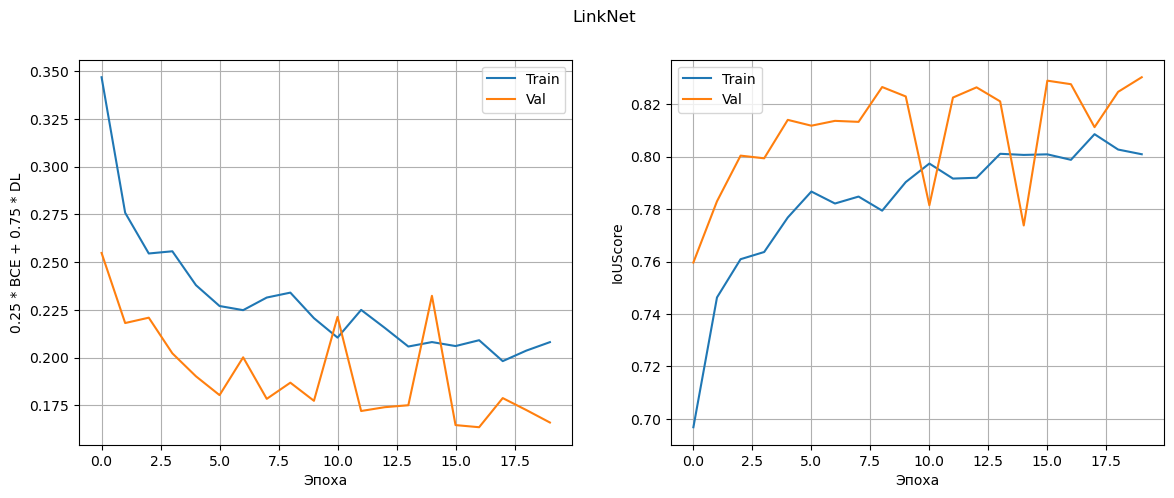

In [52]:
plot_result('LinkNet', '0.25 * BCE + 0.75 * DL', train_loss_L[0], val_loss_L[0], train_metric_L[0], val_metric_L[0])

Лучшее значение IOUscore на валидации на 20ой эпохе.

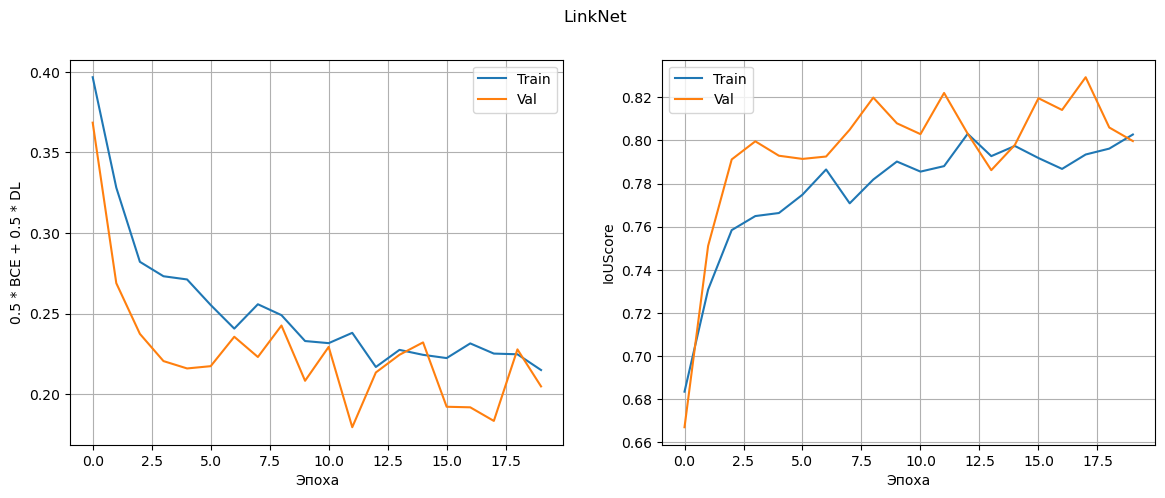

In [53]:
plot_result('LinkNet', '0.5 * BCE + 0.5 * DL', train_loss_L[1], val_loss_L[1], train_metric_L[1], val_metric_L[1])

Лучшее значение IOUscore на валидации на 18ой эпохе.

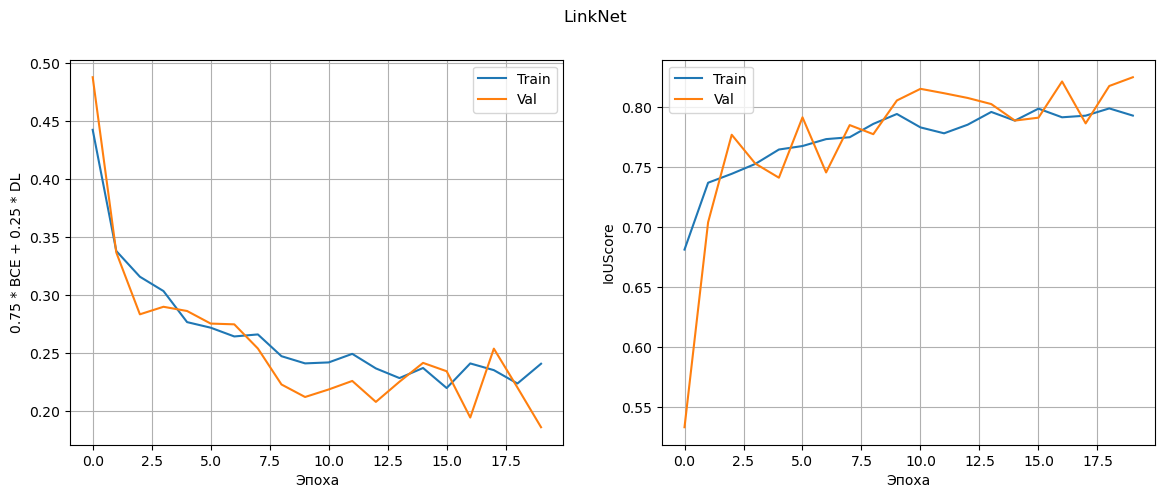

In [54]:
plot_result('LinkNet', '0.75 * BCE + 0.25 * DL', train_loss_L[2], val_loss_L[2], train_metric_L[2], val_metric_L[2])

Лучшее значение IOUscore на валидации на 20ой эпохе.

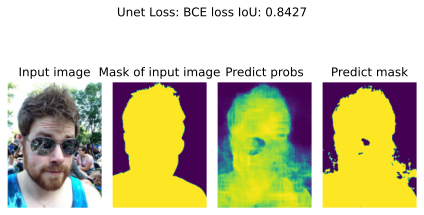

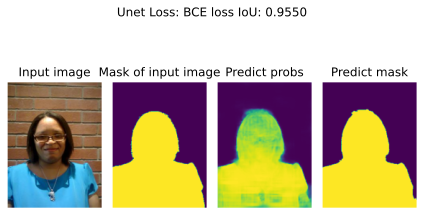

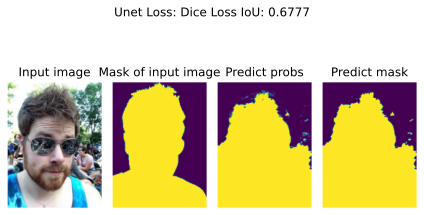

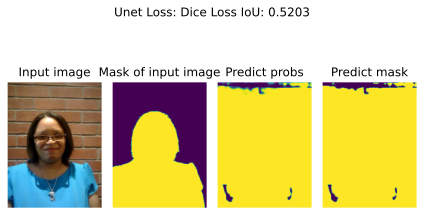

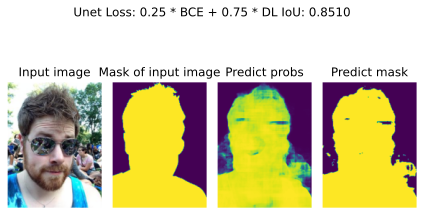

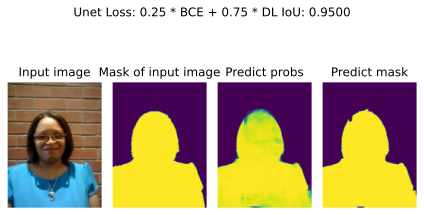

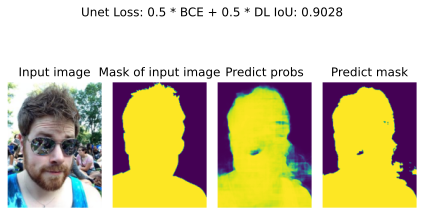

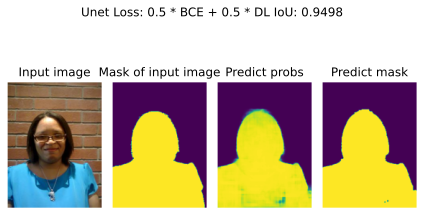

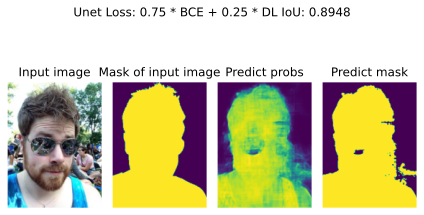

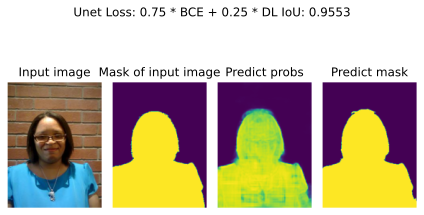

In [33]:
metric = IoUScore(threshold=0, reduction='mean')
UNet_paths = ['UNET_CE_exp_12epoch_train.pth', 'UNET_DL_exp_20epoch_train.pth', 'UNET_exp_1_17epoch_train.pth', 'UNET_exp_2_20epoch_train.pth', 'UNET_exp_3_15epoch_train.pth']
name = ['Unet Loss: BCE loss', 'Unet Loss: Dice Loss', 'Unet Loss: 0.25 * BCE + 0.75 * DL', 'Unet Loss: 0.5 * BCE + 0.5 * DL', 'Unet Loss: 0.75 * BCE + 0.25 * DL']
for (i, path) in enumerate(UNet_paths):
    model = UNet()
    model.load_state_dict(torch.load('checkpoints/' + path, map_location=torch.device('cpu')))
    fig1 = show_set_img(model, test_dataset, 50)
    fig2 = show_set_img(model, test_dataset, 18)
    num1 = metric(model(test_dataset[50][0][None,]), test_dataset[50][1][None,]).item()
    num2 = metric(model(test_dataset[18][0][None,]), test_dataset[18][1][None,]).item()
    fig1.suptitle(name[i] + ' IoU: ' + f'{num1:.4f}')
    fig2.suptitle(name[i] + ' IoU: ' + f'{num2:.4f}')
    plt.show()


In [34]:
LinkNet_paths = ['LinkNet_CE_exp_15epoch_train.pth', 'LinkNet_exp_2_18epoch_train.pth', 'LinkNet_DL_exp_20epoch_train.pth', 'LinkNet_exp_1_20epoch_train.pth', 
'LinkNet_exp_3_20epoch_train.pth']

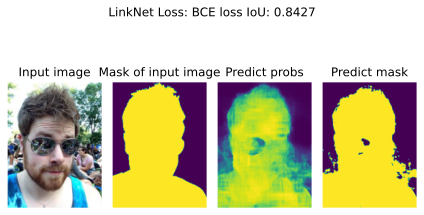

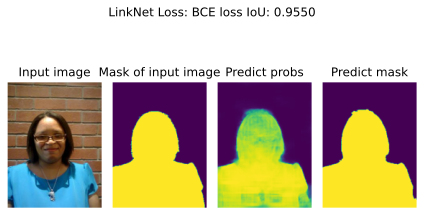

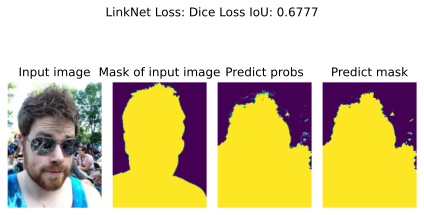

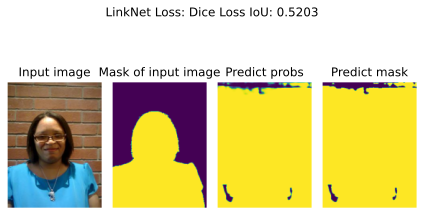

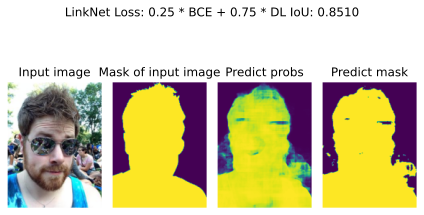

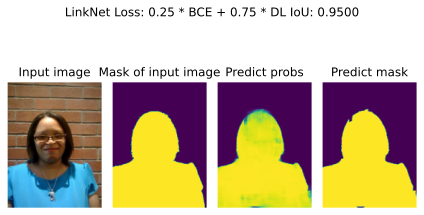

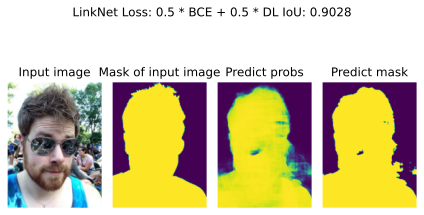

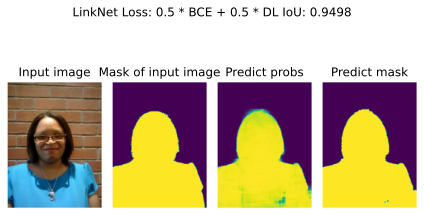

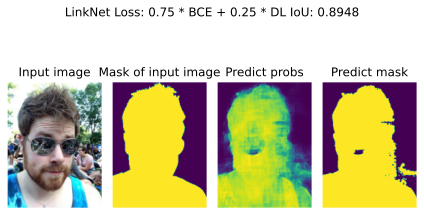

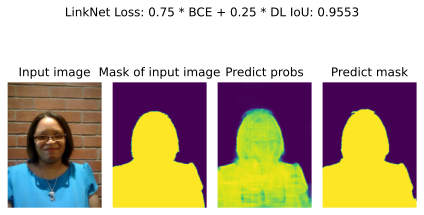

In [35]:
name = ['LinkNet Loss: BCE loss', 'LinkNet Loss: Dice Loss', 'LinkNet Loss: 0.25 * BCE + 0.75 * DL', 'LinkNet Loss: 0.5 * BCE + 0.5 * DL', 'LinkNet Loss: 0.75 * BCE + 0.25 * DL']
for (i, path) in enumerate(UNet_paths):
    model = UNet()
    model.load_state_dict(torch.load('checkpoints/' + path, map_location=torch.device('cpu')))
    fig1 = show_set_img(model, test_dataset, 50)
    fig2 = show_set_img(model, test_dataset, 18)
    num1 = metric(model(test_dataset[50][0][None,]), test_dataset[50][1][None,]).item()
    num2 = metric(model(test_dataset[18][0][None,]), test_dataset[18][1][None,]).item()
    fig1.suptitle(name[i] + ' IoU: ' + f'{num1:.4f}')
    fig2.suptitle(name[i] + ' IoU: ' + f'{num2:.4f}')
    plt.show()

Таблица ниже составлена на основе данных, извлеченных из тензорборда.

In [41]:
import pandas as pd
col = ['IoU на валидации', 'Время обучения']
func = ['BCE loss', 'BCE loss', 'Dice Loss', 'Dice Loss', '0.25 * BCE + 0.75 * DL', '0.25 * BCE + 0.75 * DL', '0.5 * BCE + 0.5 * DL', '0.5 * BCE + 0.5 * DL', '0.75 * BCE + 0.25 * DL', '0.75 * BCE + 0.25 * DL']
alghoritm = ['UNet', 'LinkNet']
tuples = list(zip(*[func, alghoritm * 5]))
index = pd.MultiIndex.from_tuples(tuples, names=['Функционал ошибки', 'Алгоритм'])
df = pd.DataFrame(index=index, columns=col)
UNet_IoU = [0.7843, 0.6663, 0.8142, 0.8315, 0.8099]
UNet_time = ['26м  1с', '24м  29с', '26м 12с', '26м 15с', '26м 21с']
LinkNet_IoU = [0.8113, 0.7276, 0.8303, 0.7997, 0.8248]
LinkNet_time = ['24м  25с', '22м  47с', '24м 22с', '24м 15с', '24м 16с']
for i in range(5):
    df[2*i:2*i + 1] = [UNet_IoU[i], UNet_time[i]]
    df[2*i + 1:2*i + 2] = [LinkNet_IoU[i], LinkNet_time[i]]
df

IoU на валидации Время обучения
Функционал ошибки      Алгоритм                                
BCE loss               UNet               0.7843        26м  1с
                       LinkNet            0.8113       24м  25с
Dice Loss              UNet               0.6663       24м  29с
                       LinkNet            0.7276       22м  47с
0.25 * BCE + 0.75 * DL UNet               0.8142        26м 12с
                       LinkNet            0.8303        24м 22с
0.5 * BCE + 0.5 * DL   UNet               0.8315        26м 15с
                       LinkNet            0.7997        24м 15с
0.75 * BCE + 0.25 * DL UNet               0.8099        26м 21с
                       LinkNet            0.8248        24м 16с

Как видно из результатов экспериментов, быстрее всего Unet и LinkNet обучается при использовании в качестве функционала ошибки Dice Loss, но при этом такие модели достигают наименьшее качество на валидации. Использование кросс-энтропии позволяет достичь существенно более высокого качества, однако самые высокие значения демонстрирует подход с использованием суммы лоссов: для UNet - 0.8315 на валидации (0.5 * Binary Cross Entropy + 0.5 * Dice Loss), для LinkNet - 0.8303 на валидации (0.25 * Binary Cross Entropy + 0.75 * Dice Loss). Отметим также, что время обучения LinkNet примерно на 2 минуты в каждом из случаев ниже чем при использовании UNet.

## `Теоретические вопросы (1 балл)`

### `Вопрос 1`
* Сформулируйте два предположения о структуре входных данных, на которые опирается архитектура свёрточных сетей. 
* Какие преимущества дает использование сверток в случае, если эти предположения верные? 
* Приведите пример входных данных, когда эти предположения не выполняются.

1. Структура входных данных должна удовлетворять следующим предположениям:
 - **Локальность образов** означает, что соседние пиксели имеют тенденцию быть коррелированными, в то время как удаленные пиксели обычно не коррелируют. Это предположение обычно делается при использовании нескольких методов обработки изображений (например, фильтров). Размер и форма окрестности могут варьироваться в зависимости от области изображения (или чего-то еще), но на практике обычно выбирается фиксированная и прямоугольная/квадратная область.  
 - **Стационарность образов** подразумевает, что можно использовать один и тот же фильтр для обнаружения одного и того же объекта в разных областях изображения.
2. Свертка намного эффективнее умножения матриц с точки зрения памяти и числа арифметических операций. Благодаря значительному уменьшению числа параметров модель проще настроить на обучающие данные.  
  
3. Пример изображений, для которых эти предположения не выполнены: 
 - **Нет локальности образов.** Например, изображение сильно случайного объекта (случайного по своей природе), для которого точно нельзя сказать, что соседние пиксели коррелированы. Подача такого изображения для нейронной сети будет похожа на подачу шума, поэтому нейронная сеть не сможет хорошо распознавать такие изображения. Наглядным примером такого изображения может служить гора мусора.
 - **Нет стационарности образов.** Пусть ставится задача детектирования машины. Возможна ситуация, когда во время обучения в тренировочной выборке были объекты лишь с машинами, которые стоят на дороге или земле. Тогда в случае перевернутой машины (этот образ перестал быть стационарным и обученная нейросеть ничего не знает про перевернутые машины) нейросеть не сможет корректно работать с таким изображением.

In [180]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://phonoteka.org/uploads/posts/2022-09/1663051599_2-phonoteka-org-p-tekstura-musora-krasivo-2.jpg")

In [181]:
Image(url= "https://www.avtovzglyad.ru/media/article/2_7dAvX0U.jpg.740x555_q85_box-0%2C0%2C2048%2C1534_crop_detail_upscale.jpg")

### `Вопрос 2`
Пусть дано множество 1-D входов ${x^{(i)} \in \mathbb{R}^{100}}$. 

Рассмотрим полносвязный слой ${f(\cdot)}$, заданный как ${f(x^{(i)}) = \sigma(Wx^{(i)})}$, где ${W}$ - матрица весов размерности ${1000\times 100}$ и ${\sigma(\cdot)}$ поэлементая функция активации. 

Рассмотрим также сверточный слой ${g(\cdot)}$ с десятью картами признаков: ${g(x^{(i)}) = \sigma([z_1, z_2,...,z_{10}])}$, где ${z_j = x^{(i)}\ast w_j}$ для некоторого ядра свертки ${w_j}$ с размером 3 и паддингом 1. Для ${f(\cdot)}$ и ${g(\cdot)}$ напишите: 

1. Размерность выходного пространства. 
2. Количество обучаемых параметров. 
3. Число операций при выполнении forward pass (при условии наивной реализации перемножения матриц и вычисления сверток).

1. Размерность выходного пространства для ${f(\cdot)}$ равна ${1000\times 1}$, для ${g(\cdot)}$ $10 \times 100$ ($z_i \in \mathbb{R}^{100}$ с учетом наличия паддинга, равного $1$, а количество каналов равно $10$).
2. Количество обучаемых параметров у ${f(\cdot)}$ равно $1000 \times 100 = 10^5$ (веса матрицы $W$), для ${g(\cdot)}$ $10 \times 3 = 30$. ($10$ каналов, где каждая свертка имеет размер $3$).
3. Число операций при выполнении forward pass для ${f(\cdot)}$: $1000 \times 100 = 10^5$ умножений, $99 \times 1000 = 99000$ сложений, $1000$ применений функции активации ${\sigma(\cdot)}$, для ${g(\cdot)}$: $100 \times 3 \times 10 = 3000$ умножений, $100 \times 2 \times 10 = 2000$ сложений и  $10 \times 100 = 1000$ применений функции активации.

## `Бонус: постобработка изображений (1 балл)`

В предложенной задаче на фотографиях необходимо сегментировать только центральное изображения. Артефакты, которые появляются на краях изображения, можно удалять с помощью постобработки (например, с помощью модуля [skimage.morphology](https://scikit-image.org/docs/dev/api/skimage.morphology.html)).

Реализуйте какой-нибудь из методов постобработки, дающий прирост в качестве. Продемонстрируйте несколько изображений, на которых постобработка будет оказывать влияние на результат сегментации.

Покажем, как влияет добавление морфологических операций на работу лучшей из моделей: UNet + (0.5 * Binary Cross Entropy + 0.5 * Dice Loss).

In [42]:
import skimage.morphology

In [165]:
def show_morph_img(model, dataset, idx, kernel1, kernel2):
    image, mask = dataset[idx]
    pred = model(image[None,].to(device)).detach()

    image = image.permute(1, 2, 0).numpy()
    image = (image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image = np.clip(image, 0, 1)

    mask = mask.squeeze(0).numpy()
    pred = pred.cpu().squeeze().numpy()

    fig, axes = plt.subplots(1, 4, figsize=(6, 4))
    
    axes[0].set_title('Input image')
    axes[0].imshow(image)
    axes[1].set_title('Mask of input image')
    axes[1].imshow(mask)
    
    axes[2].set_title('Predict mask')
    axes[2].imshow((pred > 0).astype(int))
    
    axes[3].set_title('Morphology mask')
    img = skimage.morphology.opening((pred > 0).astype(int), np.ones(kernel1))
    img = skimage.morphology.closing(img, np.ones(kernel2))
    axes[3].imshow(img)
    
    axes[0].set_axis_off()
    axes[1].set_axis_off()
    axes[2].set_axis_off()
    axes[3].set_axis_off()
    
    fig.tight_layout()
    return fig

In [71]:
model = UNet()
model.load_state_dict(torch.load('checkpoints/UNET_exp_2_20epoch_train.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [166]:
def morph_num(model, idx, kernel1, kernel2):
    tr = transforms.ToTensor()
    pred = model(test_dataset[idx][0][None,].to(device)).detach().cpu().squeeze().numpy()
    mask = skimage.morphology.opening((pred > 0).astype(int), np.ones(kernel1))
    mask = skimage.morphology.closing(mask, np.ones(kernel2))
    return metric(tr(mask), test_dataset[idx][1][None,]).item()

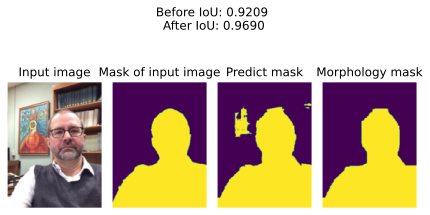

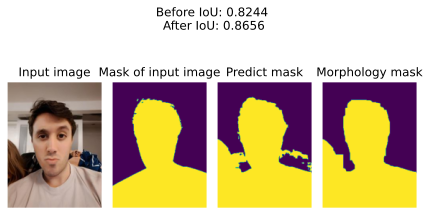

Opening kernel size: (30, 30)
Closing kernel size: (10, 10)


In [171]:
idx1, idx2 = 17, 10
kernel1, kernel2 = (30, 30), (10, 10)
fig1 = show_morph_img(model, test_dataset, idx1, kernel1, kernel2)
fig2 = show_morph_img(model, test_dataset, idx2, kernel1, kernel2)
pred1 = model(test_dataset[idx1][0][None,].to(device)).detach().cpu().squeeze().numpy()
num1b = metric(model(test_dataset[idx1][0][None,]), test_dataset[idx1][1][None,]).item()
num1a = morph_num(model, idx1, kernel1, kernel2)
num2b = metric(model(test_dataset[idx2][0][None,]), test_dataset[idx2][1][None,]).item()
num2a = morph_num(model, idx2, kernel1, kernel2)
fig1.suptitle('Before IoU: ' + f'{num1b :.4f}\n After IoU: ' + f'{num1a:.4f}\n')
fig2.suptitle('Before IoU: ' + f'{num2b:.4f}\n After IoU: ' + f'{num2a:.4f}\n')
plt.show()
print('Opening kernel size:', kernel1)
print('Closing kernel size:', kernel2)

In [179]:
from tqdm import tqdm
total_metric_a, total_metric_b, n = 0.0, 0.0, 0
kernel1, kernel2 = (30, 30), (10, 10)
with torch.no_grad():
    for idx in tqdm(range(len(test_dataset))): 
        metric_b = metric(model(test_dataset[idx][0][None,]), test_dataset[idx][1][None,]).item()
        metric_a = morph_num(model, idx, kernel1, kernel2) 
        total_metric_b += metric_b
        if metric_b > metric_a:
            metric_a = metric_b
        total_metric_a += metric_a 

print(f'Val before metric: {total_metric_b / len(test_dataset)}')
print(f'Val after metric: {total_metric_a / len(test_dataset)}')

100%|██████████| 141/141 [05:23<00:00,  2.30s/it]

Val before metric: 0.831902563149202
Val after metric: 0.8412225369020556


Таким образом, получили прирост в качестве при использованиия морфологических операций: открытие (с ядром $30 \times 30$), закрытие (c ядром $10 \times 10$).

## `Бонус: существенное улучшение качества (2 балла)`

Придумайте какой-нибудь трюк, который существенно (с учётом бонусного пункта 1) повысит качество (которое должно быть и так достаточно высоко). Не разрешается использовать дополнительные данные или другие предобученные кодировщики кроме VGG13.

Если вы что-то попробовали, но качество не повысилось, всё равно оформите этот пункт, даже за неудачные попытки могут быть начислены баллы.

## `Бонус: обучение с использованием сторонних фреймворков (1 балл)`

Попробуйте обучить свою модель с использованием одного из следующих фреймворков: [catalyst](https://github.com/catalyst-team/catalyst), [pytorch-lightning](https://www.pytorchlightning.ai/), [ignite](https://github.com/pytorch/ignite).

## `Бонус: аугментации (0.5 балла)`

Воспользуйтесь сторонними библиотеками для аугментаций, например, [deepaugment](https://github.com/barisozmen/deepaugment) и [albumentations](https://albumentations.ai/) для улучшения качества модели.

## `Бонус: torch.compile (0.25 балла)`

Попробуйте установить [Pytorch 2.0](https://pytorch.org/get-started/pytorch-2.0/) и запустите обучение с использованием `torch.compile`. Тщательно сравните время с и без использованием компиляции.

*Замечание:* обязательно укажите конфигурацию системы (версия OS, модель CPU/GPU, объём RAM), на которой производилось обучение. В частности, приложите вывод команд:
```bash
! nvcc --version
! nvidia-smi
```